In [1]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

import csv
import umap
import scanpy as sc

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['savefig.format'] = 'pdf'

cwd = os.getcwd()
os.chdir('/data/cb/alexwu/mm_finemap')
from analysis import *
os.chdir(cwd)

## Compare Motif Changes to Disease Associations

### GrID-Net Scores

In [3]:
from collections import Counter

distance = 250000
n_layers = 10
n_neighbors = 15
mode = 'lr'

dataset = 'human_cortex_multiome_lineage'
sampling = 'uniform'

rna_adata,atac_adata,eval_df = load_data(dataset,sampling=sampling,gene_percent_cells=0.01,
                                          peak_percent_cells=0.001,include_h5=True,
                                          distance=distance,preprocess=False)

eval_df = load_results(dataset,eval_df,ensemble=True,distance=distance)
eval_df['gene'] = eval_df['gene'].str.decode('utf-8').values
eval_df['abs_dist'] = abs(eval_df['dist'])

rna_adata.obs['cell_type_broad'] = [n[:-1] if 'GluN' in n else n for n in rna_adata.obs['cell_type']]

Only considering the two last: ['.uniform', '.h5ad'].
Only considering the two last: ['.uniform', '.h5ad'].
Only considering the two last: ['.uniform', '.h5ad'].
Only considering the two last: ['.uniform', '.h5ad'].
<KeysViewHDF5 ['ABC.score', 'atac_id', 'chr_no', 'corr', 'dist', 'eqtl.all', 'eqtl.fdr', 'eqtl.gtex', 'gene', 'gene_percent_cells', 'group_corr', 'hic', 'hic.new', 'peak_percent_cells', 'placseq_IPC', 'placseq_RG', 'placseq_eN', 'placseq_iN']>


### Use Canonical TSS

In [4]:
save_dir = '/data/cb/alexwu/mm_finemap/data/ucsc'

bed_df = pd.read_csv(os.path.join(save_dir,'gencodeV39.bed'),sep='\t',header=None)
bed_df[3] = bed_df[17]
bed_df = bed_df.iloc[[i for i,n in enumerate(bed_df[0]) if 'alt' not in n]]
bed_df = bed_df[bed_df[22] == 'protein_coding']
bed_df = bed_df[bed_df[25] == 'canonical,basic,all']
# bed_df = bed_df[bed_df[21] == 'havana_homo_sapiens']

# # save canonical TSS (for use in pygenomebrowser)
bed_df.iloc[:,0:12].to_csv(os.path.join(save_dir,'gencodeV39_bed12.bed'),sep='\t',header=False,index=False)

canonical_tss_dict = {g: tss_plus if direction == '+' else tss_minus 
                      for g,tss_plus,tss_minus,direction in bed_df[[3,1,2,5]].values}

new_txstart = []
k = 0
for g,tss in zip(*[rna_adata.var.index.values,rna_adata.var['txstart'].values]):
    if g in canonical_tss_dict:
        new_txstart.append(canonical_tss_dict[g])
        k += 1
    else:
        new_txstart.append(tss)
print(k,rna_adata.shape[1])
        
rna_adata.var['txstart'] = new_txstart

19001 24493


In [5]:
from sklearn.linear_model import LogisticRegression

def transform_X(df,score_key):

#     X = df[[score_key,'log_dist']].values
    X = np.array([np.log(1e-10+df[score_key]),np.clip(np.log10(1+df['abs_dist']),4,10)-4]).T
#     X = np.log10(1e-5 + df[[score_key,'abs_dist']].values)

    return X

def string2coeffs(coeff_str):
    
    values = np.array([float(v) for v in [n.strip('[ ]') 
                        for n in coeff_str.split(' ')] if len(v)])
    
    return np.array([values[0:2]]),np.array([values[2]])

lr = LogisticRegression(penalty='none',fit_intercept=True)

coeff_str = '[[ 0.28047717 -0.3394994 ]] [-3.62364303]'
coeff_str = '[[ 0.28332471 -0.16272753]] [-3.66021169]'
# coeff_str = '[[ 0.77661531 -0.47272459]] [-10.50656008]' # using 10^-10 for eQTL predictions


lr.coef_,lr.intercept_ = string2coeffs(coeff_str)
lr.classes_ = np.array([0,1])

score_key = 'graph.ranks.mean'
X = transform_X(eval_df,score_key)

eval_df['{}-LR-dist'.format(score_key)] = lr.predict_proba(X)[:,1]

### Save Peak-Gene Links to File

In [6]:
peak_pos_dict = {i: (chr_no,start,end) for i,(chr_no,start,end) 
                 in enumerate(atac_adata.var[['seqnames','start','end']].values)}

In [23]:
save_eval_df = eval_df[['gene','atac_id',score_key]]

In [24]:
save_eval_df['chr_no'] = [peak_pos_dict[n][0] for n in eval_df['atac_id'].values]
save_eval_df['peak_start'] = [peak_pos_dict[n][1] for n in eval_df['atac_id'].values]
save_eval_df['peak_end'] = [peak_pos_dict[n][2] for n in eval_df['atac_id'].values]

/tmp/ipykernel_2095657/58329122.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  save_eval_df['chr_no'] = [peak_pos_dict[n][0] for n in eval_df['atac_id'].values]
/tmp/ipykernel_2095657/58329122.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  save_eval_df['peak_start'] = [peak_pos_dict[n][1] for n in eval_df['atac_id'].values]
/tmp/ipykernel_2095657/58329122.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

In [25]:
del save_eval_df['atac_id']
save_eval_df['gridnet_score'] = save_eval_df[score_key].values
del save_eval_df[score_key]

/tmp/ipykernel_2095657/1203399307.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  save_eval_df['gridnet_score'] = save_eval_df[score_key].values


In [26]:
save_dir = '/data/cb/alexwu/mm_finemap/misc'

save_eval_df.to_csv(os.path.join(save_dir,'gridnet_corticogenesis.txt'),sep='\t',index=False)

## Load Disease Genes

In [7]:
n_rank = 3
score_percentile = 50

N = 20
score_key = 'graph.ranks.mean-LR-dist'

threshold = np.percentile(eval_df[score_key].values,score_percentile)

sampling = 'uniform'

per_variant = True
diseases2keep = ['schizophrenia_nature']

dataset = 'human_cortex_multiome_lineage'

combined_df_dict = {}
counts_df_dict = {}
for trait in diseases2keep:

    # get predicted variant-gene links
    combined_df = get_disease_gene_ranks(score_key,sampling,trait,
                                         score_percentile=0,
                                         per_variant=per_variant,
                                         N=N)

    combined_df = combined_df[combined_df['rank'] < n_rank]
    combined_df = combined_df[combined_df['gwas_pp'] > 0.05]
    combined_df = combined_df.drop_duplicates()

    # threshold by GrID-Net score
    combined_df = combined_df[combined_df[score_key] >= threshold]

    if per_variant:
        combined_df['chr_no'] = [n.split('-')[0] for n in combined_df['variant']]
        combined_df['pos'] = [int(float(n.split('-')[1])) for n in combined_df['variant']]

    if combined_df.shape[0]:
        combined_df_dict[trait] = combined_df

        counts_df = pd.DataFrame(np.array(Counter(combined_df['gene']).most_common()),columns=['gene','counts'])
        counts_df['counts'] = counts_df['counts'].astype(int)
        counts_df.index = counts_df['gene'].values
        counts_df['rank'] = np.arange(counts_df.shape[0]) + 1
        counts_df_dict[trait] = counts_df

## TF Binding Changes
### Load FIMO Results

In [9]:
results_dir = '/data/cb/alexwu/mm_finemap/results/gwas/fimo/schizophrenia_nature'

flank_size = 20

filtered_ref_df_list = []
filtered_variant_df_list = []
for motif_set in ['cisbp'] + ['hocomoco','jaspar']:

    ref_df = pd.read_csv(os.path.join(results_dir,'ref_{}'.format(motif_set),'fimo.filtered.tsv'),sep='\t')
    variant_df = pd.read_csv(os.path.join(results_dir,'variant_{}'.format(motif_set),'fimo.filtered.tsv'),sep='\t')

    if motif_set == 'jaspar' or motif_set == 'cisbp':
        ref_df['tf'] = ref_df['motif_alt_id'].values
        variant_df['tf'] = variant_df['motif_alt_id'].values
    
    # filter on flank size
    filtered_ref_df = ref_df[ref_df['flank_size'] == flank_size]
    filtered_variant_df = variant_df[variant_df['flank_size'] == flank_size]
    
    # filter on motifs that directly overlap variant
    overlap_cond = (filtered_ref_df['start'] <= (flank_size+1)) & (filtered_ref_df['stop'] >= (flank_size+1))
    filtered_ref_df = filtered_ref_df[overlap_cond]
    overlap_cond = (filtered_variant_df['start'] <= (flank_size+1)) & (filtered_variant_df['stop'] >= (flank_size+1))
    filtered_variant_df = filtered_variant_df[overlap_cond]
    
    filtered_ref_df['motif_set'] = motif_set
    filtered_variant_df['motif_set'] = motif_set
    
    filtered_ref_df_list.append(filtered_ref_df)
    filtered_variant_df_list.append(filtered_variant_df)
    
filtered_ref_df = pd.concat(filtered_ref_df_list)
filtered_variant_df = pd.concat(filtered_variant_df_list)
    
keys = ['tf','pos','start','stop','strand','score','p-value','motif_set','matched_sequence']
ref_dict = {(pos,tf,start,stop,strand,motif_set): (score,q,seq) for tf,pos,start,stop,strand,score,q,motif_set,seq 
            in filtered_ref_df[keys].values}
variant_dict = {(pos,tf,start,stop,strand,motif_set): (score,q,seq) for tf,pos,start,stop,strand,score,q,motif_set,seq 
                in filtered_variant_df[keys].values}

keys = ['tf','pos','start','stop','strand','ref_score','variant_score',
        'ref_p','variant_p','ref_seq','variant_seq','motif_set']
data_dict = {k: [] for k in keys}
for (pos,tf,start,stop,strand,motif_set) in ref_dict.keys():
    if (pos,tf,start,stop,strand,motif_set) in variant_dict:
        
        ref_score,ref_q,ref_seq = ref_dict[(pos,tf,start,stop,strand,motif_set)]
        variant_score,variant_q,variant_seq = variant_dict[(pos,tf,start,stop,strand,motif_set)]
        
        data_dict['pos'].append(pos)
        data_dict['start'].append(start)
        data_dict['stop'].append(stop)
        data_dict['strand'].append(strand)
        data_dict['tf'].append(tf)
        data_dict['ref_score'].append(ref_score)
        data_dict['variant_score'].append(variant_score)
        
        data_dict['ref_p'].append(ref_q)
        data_dict['variant_p'].append(variant_q)
        data_dict['ref_seq'].append(ref_seq)
        data_dict['variant_seq'].append(variant_seq)
        
        data_dict['motif_set'].append(motif_set)

data_df = pd.DataFrame(data_dict)
data_df['-log10ref_p'] = -np.log10(data_df['ref_p'].values)
data_df['-log10variant_p'] = -np.log10(data_df['variant_p'].values)

### Annotating Variants: Nearest Gene + rsID + in GrID-Net Links

In [10]:
trait = 'schizophrenia_nature'
data_dir = '/data/cb/alexwu/mm_finemap/data/gwas/human_cortex_multiome'
file_name = '{}.credible_sets.txt.gz'.format(trait)

# pip_keys = ['PAINTOR','CAVIARBF','FINEMAP']
gwas_df = pd.read_csv(os.path.join(data_dir,file_name),sep='\t',compression='gzip')

hg38_hg19_convert_dict = {'{}-{}'.format(chr_lift,int(pos_lift)): 'chr{}-{}'.format(chr_no,int(pos))
                          for chr_lift,pos_lift,chr_no,pos in 
                        gwas_df[['chr_liftover','pos_liftover','chromosome','position']].values}

# closest gene to variant 
nearest_gene_dict = {}
for chr_no in list(set(gwas_df['chr_liftover'])):
    
    filtered_gwas_df = gwas_df[gwas_df['chr_liftover'] == chr_no]
    filtered_gene_df = rna_adata.var[rna_adata.var['chr_no'] == chr_no]
    
    for chr_no,pos,pos_liftover in filtered_gwas_df[['chromosome','position','pos_liftover']].values:
        nearest_gene = filtered_gene_df.index.values[np.argmin(abs(pos_liftover-filtered_gene_df['txstart'].values))]
        nearest_gene_dict['chr{}-{}'.format(int(chr_no),int(pos))] = nearest_gene
        
# rsID
pos2rsid_dict = {'chr{}-{}'.format(int(chr_no),int(pos)): rsid for chr_no,pos,rsid 
                 in gwas_df[['chromosome','position','rsid']].values}

In [11]:
combined_df['variant_orig'] = [hg38_hg19_convert_dict['{}-{}'.format(chr_no,int(pos))] 
                               for chr_no,pos in combined_df[['chr_no','pos']].values]

# nearest gene
combined_df['nearest_gene'] = [nearest_gene_dict[pos] for pos in combined_df['variant_orig'].values]
combined_df['isNearestGene'] = combined_df['nearest_gene'].values == combined_df['gene'].values

# rsID
combined_df['rsID'] = [pos2rsid_dict[pos] for pos in combined_df['variant_orig'].values]

# variant in GrID-Net links (also filters for GWAS PP > 0.05)?
data_df['inLinks'] = [pos in combined_df['variant_orig'].values for pos in data_df['pos'].values]

### Comparing against SCZ GWAS Hits

In [12]:
data_dir = '/data/cb/alexwu/mm_finemap/data/gwas/human_cortex_multiome/nature_scz_papers'

credible_sets_df = pd.read_csv(os.path.join(data_dir,'Supp_Table11.credible_sets.csv'))
prioritized_df = pd.read_csv(os.path.join(data_dir,'Supp_Table12.prioritized_genes.csv'))

#### Summary

In [13]:
print('# of index SNPs (broad set):\t',len(set(credible_sets_df['index_snp'])))
print('# of index SNPs (prioritized):\t',len(set(prioritized_df['Index.SNP'])))

# of index SNPs (broad set):	 255
# of index SNPs (prioritized):	 109


#### Variants Overlapping Peaks

In [14]:
trait = 'schizophrenia_nature'
finemap_key = 'finemap_posterior_probability'
pp_thresh = 0.05

data_dir = '/data/cb/alexwu/mm_finemap/data/gwas/human_cortex_multiome'
file_name = '{}.credible_sets.txt.gz'.format(trait)

gwas_df = pd.read_csv(os.path.join(data_dir,file_name),sep='\t',compression='gzip')

# filter GWAS variants by PP
gwas_df = gwas_df[gwas_df[finemap_key] >= pp_thresh]

In [15]:
print('# of GWAS variants with PP>=0.05:\t',credible_sets_df[credible_sets_df[finemap_key] >= 0.05].shape[0])
print('# of GWAS variants with PP>=0.05 that overlap ATAC peaks:\t',gwas_df[gwas_df['atac_id'].notna()].shape[0])

# of GWAS variants with PP>=0.05:	 1289
# of GWAS variants with PP>=0.05 that overlap ATAC peaks:	 195


In [23]:
195/1289

0.15128006206361522

#### Broad Set

In [24]:
# includes genes that contain at least one credible SNP 
# (INTERGENIC VARIANTS NOT ASSIGNED GENES IN BROAD SET - ONLY WHEN USING SMR)
thresh = 0.0
len(set(credible_sets_df[credible_sets_df['finemap_posterior_probability'] >= thresh]['gene_symbol']))

broadset_genes = set(credible_sets_df[credible_sets_df['finemap_posterior_probability'] >= thresh]['gene_symbol'])

print('Intersection of broad set & our SCZ genes:\t',len(broadset_genes & set(combined_df['gene'])))
print('# of broad set genes:\t\t\t\t',len(broadset_genes))
print('# of our SCZ genes:\t\t\t\t',len(set(combined_df['gene'])))

Intersection of broad set & our SCZ genes:	 44
# of broad set genes:				 653
# of our SCZ genes:				 132


#### SMR-Implicated Candidate Genes (eQTL or Hi-C-based)
(not yet "prioritized")

In [17]:
data_dir = '/data/cb/alexwu/mm_finemap/data/gwas/human_cortex_multiome/nature_scz_papers'

smr_candidates_df = pd.read_csv(os.path.join(data_dir,'Supp_Table17d.SMR_implicated_genes.csv'))

In [18]:
print('Intersection of SMR genes & our SCZ genes:\t',len(set(smr_candidates_df['Gene']) & set(combined_df['gene'])))
print('# of SMR genes & our SCZ genes:\t\t\t',len(set(smr_candidates_df['Gene'])))

Intersection of SMR genes & our SCZ genes:	 7
# of SMR genes & our SCZ genes:			 101


#### Prioritized Set

In [25]:
# comparison of fine-mapped rsIDs
print('Overlap between prioritized index SNPs & SNPs we link to genes:\t',
      len(set(prioritized_df['Index.SNP']) & set(combined_df[combined_df['gwas_pp'] >= thresh]['rsID'])))
print('# of prioritized index SNPs:\t\t\t\t\t',len(set(prioritized_df['Index.SNP'])))
print('# of SNPs we link to genes:\t\t\t\t\t',len(set(combined_df[combined_df['gwas_pp'] >= thresh]['rsID'])))


set(prioritized_df['Index.SNP']) & set(combined_df[combined_df['gwas_pp'] >= thresh]['rsID'])

Overlap between prioritized index SNPs & SNPs we link to genes:	 12
# of prioritized index SNPs:					 109
# of SNPs we link to genes:					 115


{'rs11210892',
 'rs11972718',
 'rs2206956',
 'rs324017',
 'rs3808581',
 'rs4702',
 'rs56205728',
 'rs58950470',
 'rs6673880',
 'rs72986630',
 'rs758749',
 'rs959071'}

In [31]:
# prioritized genes vs. our genes
thresh = 0 # GWAS SCZ paper only retains variants with PP >= 0.1

print('Overlap between prioritized genes & our genes:\t',
      len(set(prioritized_df['Symbol.ID']) & set(combined_df[combined_df['gwas_pp'] >= thresh]['gene'])))

set(prioritized_df['Symbol.ID']) & set(combined_df[combined_df['gwas_pp'] >= thresh]['gene'])

Overlap between prioritized genes & our genes:	 14


{'BNIP3L',
 'C12orf43',
 'EMX1',
 'FURIN',
 'HYI',
 'IRF3',
 'MSI2',
 'NAB2',
 'PAK6',
 'PLCH2',
 'RNASEH2C',
 'THOC7',
 'ZNF823',
 'ZNF835'}

In [21]:
# comparison of rsID-gene pairs
prioritized_rsid_gene_pairs = {(rsid,g) for rsid,g in prioritized_df[['Index.SNP','Symbol.ID']].values}
our_rsid_gene_pairs = {(rsid,g) for rsid,g in combined_df[['rsID','gene']].values}

print('GWAS prioritized rsID-gene pairs:\t',len(prioritized_rsid_gene_pairs),'(one gene per index SNP)')
print('our rsID-gene pairs:\t\t\t',len(our_rsid_gene_pairs))

print('overlap:',len(prioritized_rsid_gene_pairs & our_rsid_gene_pairs),'\n')
for g in (prioritized_rsid_gene_pairs & our_rsid_gene_pairs):
    print(g,combined_df[(combined_df['gene'] == g[1]) & (combined_df['rsID'] == g[0])]['dist'].values)

GWAS prioritized rsID-gene pairs:	 120 (one gene per index SNP)
our rsID-gene pairs:			 235
overlap: 8 

('rs3808581', 'BNIP3L') [-2729.]
('rs758749', 'ZNF835') [6323.]
('rs56205728', 'PAK6') [692.]
('rs4702', 'FURIN') [1867.]
('rs11210892', 'HYI') [180185.]
('rs324017', 'NAB2') [1695.]
('rs6673880', 'PLCH2') [-34119.]
('rs72986630', 'ZNF823') [247.]


In [108]:
# comparison of rsID-gene pairs (for SMR-identified pairs)
prioritized_rsid_gene_pairs = {(rsid,g) for rsid,g in 
                               prioritized_df[prioritized_df['SMR.priority.gene'] == 1][['Index.SNP','Symbol.ID']].values}
our_rsid_gene_pairs = {(rsid,g) for rsid,g in combined_df[['rsID','gene']].values}

print('GWAS prioritized rsID-gene pairs:\t',len(prioritized_rsid_gene_pairs),'(one gene per index SNP)')
print('our rsID-gene pairs:\t\t\t',len(our_rsid_gene_pairs))

print('overlap:',len(prioritized_rsid_gene_pairs & our_rsid_gene_pairs),'\n')
for g in (prioritized_rsid_gene_pairs & our_rsid_gene_pairs):
    print(g,combined_df[(combined_df['gene'] == g[1]) & (combined_df['rsID'] == g[0])]['dist'].values)

GWAS prioritized rsID-gene pairs:	 55 (one gene per index SNP)
our rsID-gene pairs:			 235
overlap: 3 

('rs4702', 'FURIN') [1867.]
('rs72986630', 'ZNF823') [247.]
('rs11210892', 'HYI') [180185.]


#### Prioritized Set: SMR (i.e. eQTL or Hi-C based) only

In [51]:
# prioritized genes vs. our genes
thresh = 0 # GWAS SCZ paper only retains variants with PP >= 0.1
set(prioritized_df[prioritized_df['SMR.priority.gene'].astype(bool)]['Symbol.ID']) & \
    set(combined_df[combined_df['gwas_pp'] >= thresh]['gene'])

{'FURIN', 'HYI', 'RNASEH2C', 'THOC7', 'ZNF823'}

#### Additional Genes Linked to Prioritized Index SNPs

In [19]:
inds2keep = [i for i,n in enumerate(combined_df['rsID']) if n in set(prioritized_df['Index.SNP'])]
combined_df.iloc[inds2keep][['rsID','gene']].sort_values('rsID')

,rsID,gene
41,rs11210892,KDM4A-AS1
42,rs11210892,ST3GAL3-AS1
43,rs11210892,HYI
247,rs11972718,ICA1
243,rs2206956,RAB32
464,rs324017,NXPH4
463,rs324017,STAT6
462,rs324017,NAB2
255,rs3808581,BNIP3L
547,rs4702,FURIN


#### Brain-specific Gene Expression
See "The Human Protein Atlas" (https://www.proteinatlas.org/about/assays+annotation#rna)

In [60]:
data_dir = '/data/cb/alexwu/mm_finemap/data/tissue_expression'
# tissue_df = pd.read_csv(os.path.join(data_dir,'normal_tissue.tsv'),sep='\t')
tissue_df = pd.read_csv(os.path.join(data_dir,'rna_tissue_consensus.tsv'),sep='\t')

In [61]:
inds2keep = [i for i,n in enumerate(combined_df['rsID']) if n in set(prioritized_df['Index.SNP'])]

genes2eval = set(combined_df.iloc[inds2keep][['rsID','gene']].sort_values('rsID')['gene'])
genes2eval = {g.split('-')[0] for g in genes2eval}
genes2eval.update({'GRM1','PCNXL3','ENSG00000262319','NXPH1'})

tissue_df = tissue_df[tissue_df['Gene name'].isin(genes2eval)]
tissue_df = pd.pivot_table(tissue_df[['Gene name','Tissue','nTPM']],
                           values='nTPM',index=['Gene name'],columns=['Tissue'])

In [62]:
brain_tissues = ['basal ganglia','cerebellum','cerebral cortex',
                 'medulla oblongata','midbrain','pons','white matter']
nonbrain_tissues = [n for n in tissue_df.columns if n not in brain_tissues]

mean_exp_null = tissue_df[nonbrain_tissues].mean(1)
std_exp_null = tissue_df[nonbrain_tissues].std(1)

In [63]:
zscore_df = pd.DataFrame((tissue_df[brain_tissues].values.T-mean_exp_null.values)/std_exp_null.values,
                         index=brain_tissues,columns=tissue_df.index)

In [64]:
(zscore_df > 1).sum(0)

Gene name
B9D1        0
BMF         0
BNIP3L      0
EPN2        7
FURIN       0
GRM1        4
HYI         1
ICA1        0
INAFM2      1
KDM4A       0
MAN2A2      6
MAP3K11     2
MORN1       1
NAB2        2
NXPH1       4
NXPH4       4
PAK6        2
PCNX3       0
PEX10       7
PLCH2       0
RAB32       0
RNASEH2C    0
ST3GAL3     0
STAT6       0
UNC45A      0
ZNF441      1
ZNF491      1
ZNF71       1
ZNF823      1
ZNF835      5
dtype: int64

#### Summary Figures

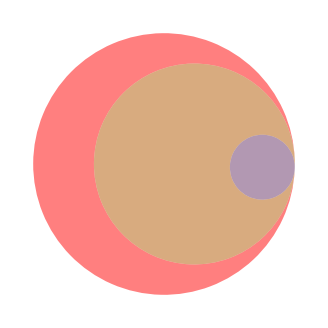

In [45]:
from matplotlib_venn import venn3

snp_overlap_peaks = set(gwas_df[gwas_df['atac_id'].notna()]['rsid'])
prioritized_index_snp = set(prioritized_df['Index.SNP'])
snp_gridnet_links = set(combined_df['rsID'])
snp_gridnet_links_and_prioritized = set(combined_df['rsID']) & prioritized_index_snp

plt.figure(figsize=(4,4))
out = venn3([snp_overlap_peaks,snp_gridnet_links,snp_gridnet_links_and_prioritized],
            ['','',''],alpha=0.5)
for idx, subset in enumerate(out.subset_labels):
    if out.subset_labels[idx] is not None:
        out.subset_labels[idx].set_visible(False)
    
plot_dir = '/data/cb/alexwu/mm_finemap/figures/'
plt.savefig(os.path.join(plot_dir,'variant_position','variant.venn_diagram.updated.pdf'), 
            dpi=500, bbox_inches = "tight")
plt.show()

#### SNP Coverage (PP >= 0.5)

In [11]:
all_snp = set(credible_sets_df[credible_sets_df['finemap_posterior_probability'] >= 0.5]['rsid'])
gridnet_link_snp = set(combined_df['rsID']) 
prioritized_snp = set(prioritized_df['Index.SNP'])

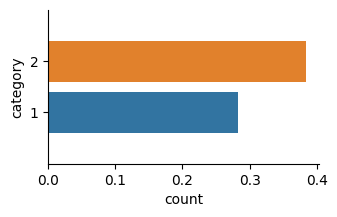

In [16]:
plot_dict = {'category': ['1','2'],
             'count': [len(prioritized_snp & all_snp)/len(all_snp),
                       len((prioritized_snp | gridnet_link_snp) & all_snp)/len(all_snp)]}

plt.figure(figsize=(3.5,2))
sns.barplot(x='count',y='category',data=pd.DataFrame(plot_dict))
plt.ylim([-1,2])
sns.despine()

plot_dir = '/data/cb/alexwu/mm_finemap/figures/'
plt.savefig(os.path.join(plot_dir,'variant_position','variant_coverage.bar_plot.pdf'), 
            dpi=500, bbox_inches = "tight")
plt.show()

In [17]:
# comparison of rsID-gene pairs
prioritized_rsid_gene_pairs = {(rsid,g) for rsid,g in prioritized_df[['Index.SNP','Symbol.ID']].values}
our_rsid_gene_pairs = {(rsid,g) for rsid,g in combined_df[['rsID','gene']].values}

print('GWAS prioritized rsID-gene pairs:\t',len(prioritized_rsid_gene_pairs),'(one gene per index SNP)')
print('our rsID-gene pairs:\t\t\t',len(our_rsid_gene_pairs))

print('overlap:',len(prioritized_rsid_gene_pairs & our_rsid_gene_pairs),'\n')
for g in (prioritized_rsid_gene_pairs & our_rsid_gene_pairs):
    print(g,combined_df[(combined_df['gene'] == g[1]) & (combined_df['rsID'] == g[0])]['dist'].values)

GWAS prioritized rsID-gene pairs:	 120 (one gene per index SNP)
our rsID-gene pairs:			 235
overlap: 8 

('rs4702', 'FURIN') [1867.]
('rs6673880', 'PLCH2') [-34119.]
('rs56205728', 'PAK6') [692.]
('rs3808581', 'BNIP3L') [-2729.]
('rs72986630', 'ZNF823') [247.]
('rs758749', 'ZNF835') [6323.]
('rs11210892', 'HYI') [180185.]
('rs324017', 'NAB2') [1695.]


In [18]:
for n in set(prioritized_df['Index.SNP']) & set(combined_df[combined_df['gwas_pp'] >= thresh]['rsID']):
    print(prioritized_df[prioritized_df['Index.SNP'] == n][['Index.SNP','Symbol.ID']].values)

[['rs959071' 'ENSG00000262319']]
[['rs4702' 'FURIN']]
[['rs56205728' 'PAK6']]
[['rs758749' 'ZNF835']]
[['rs324017' 'NAB2']]
[['rs6673880' 'PLCH2']]
[['rs3808581' 'BNIP3L']]
[['rs11972718' 'NXPH1']]
[['rs11210892' 'HYI']]
[['rs58950470' 'PCNXL3']]
[['rs72986630' 'ZNF823']]
[['rs2206956' 'GRM1']]


In [59]:
for n in set(prioritized_df['Index.SNP']) & set(combined_df[combined_df['gwas_pp'] >= thresh]['rsID']):
    print(combined_df[combined_df['rsID'] == n][['rsID','gene']].values)

[['rs11210892' 'KDM4A-AS1']
 ['rs11210892' 'ST3GAL3-AS1']
 ['rs11210892' 'HYI']]
[['rs324017' 'NAB2']
 ['rs324017' 'STAT6']
 ['rs324017' 'NXPH4']]
[['rs56205728' 'PAK6']
 ['rs56205728' 'INAFM2']
 ['rs56205728' 'BMF']]
[['rs4702' 'MAN2A2']
 ['rs4702' 'FURIN']
 ['rs4702' 'UNC45A']]
[['rs3808581' 'BNIP3L']]
[['rs72986630' 'ZNF823']
 ['rs72986630' 'ZNF441']
 ['rs72986630' 'ZNF491']]
[['rs2206956' 'RAB32']]
[['rs758749' 'ZNF71']
 ['rs758749' 'MIMT1']
 ['rs758749' 'ZNF835']]
[['rs11972718' 'ICA1']]
[['rs959071' 'EPN2-AS1']
 ['rs959071' 'B9D1']]
[['rs6673880' 'PLCH2']
 ['rs6673880' 'PEX10']
 ['rs6673880' 'MORN1']]
[['rs58950470' 'MAP3K11']
 ['rs58950470' 'PCNX3']
 ['rs58950470' 'RNASEH2C']]


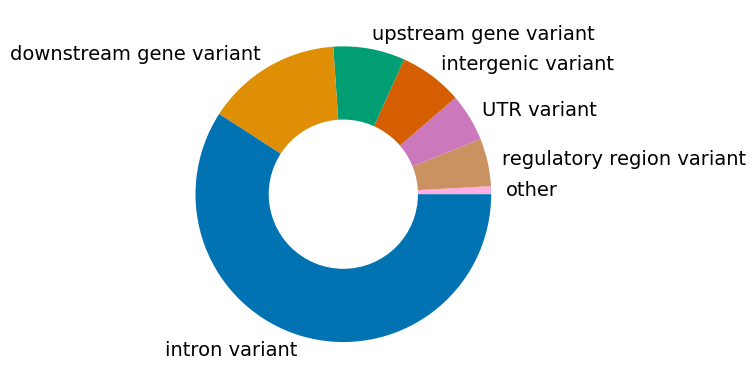

In [16]:
annot2keep = ['downstream_gene_variant', 'intron_variant', 'upstream_gene_variant', 
              'intergenic_variant', 'UTR variant', 'regulatory_region_variant'] #'missense_variant', 

hierarchy_dict = {
                  'TF_binding_site_variant': 'regulatory_region_variant',
                  'intron_variant,non_coding_transcript_variant': 'intron_variant',
                  '5_prime_UTR_variant': 'UTR variant',
                  '3_prime_UTR_variant': 'UTR variant',
                  }

variant_impact_dict = {'{}-{}'.format(chr_no,int(pos)): impact for chr_no,pos,impact 
                       in gwas_df[['chr_liftover','pos_liftover','impact']].values}

links_impact_list = []
for variant in set(combined_df['variant']):
    links_impact_list.append(variant_impact_dict[variant])

# rename annotation
links_impact_list = [hierarchy_dict[k] if k in hierarchy_dict else k for k in links_impact_list]
links_impact_list = [n if n in annot2keep else 'other' for n in links_impact_list]

links_annot_counts = Counter(links_impact_list)

values = []
labels = []
for k in [k for k,v in sorted(links_annot_counts.items(),key=lambda item: item[1])]: # + ['other']:
    labels.append(' '.join(k.split('_')))
    values.append(links_annot_counts[k])
    
colors = sns.color_palette('colorblind')[0:len(set(labels))]
colors.reverse()
plt.pie(values,labels=labels,textprops={'fontsize': 14},colors=colors)

my_circle=plt.Circle( (0,0), 0.5, color='white')
p=plt.gcf()
p.gca().add_artist(my_circle)

# plt.legend(bbox_to_anchor=(2,1))

plot_dir = '/data/cb/alexwu/mm_finemap/figures'
# plt.savefig(os.path.join(plot_dir,'variant_position','variant_position.in_peak_gene.pdf'), dpi=500, bbox_inches = "tight")
plt.show()

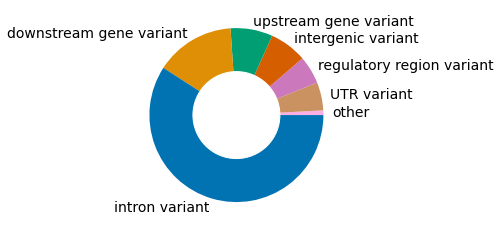

In [12]:
annot2keep = ['downstream_gene_variant', 'intron_variant', 'upstream_gene_variant', 
              'intergenic_variant', 'UTR variant', 'regulatory_region_variant'] #'missense_variant', 

hierarchy_dict = {
                  'TF_binding_site_variant': 'regulatory_region_variant',
                  'intron_variant,non_coding_transcript_variant': 'intron_variant',
                  '5_prime_UTR_variant': 'UTR variant',
                  '3_prime_UTR_variant': 'UTR variant',
                  }

variant_impact_dict = {'{}-{}'.format(chr_no,int(pos)): impact for chr_no,pos,impact 
                       in gwas_df[['chr_liftover','pos_liftover','impact']].values}

links_impact_list = []
for variant in set(combined_df['variant']):
    links_impact_list.append(variant_impact_dict[variant])

# rename annotation
links_impact_list = [hierarchy_dict[k] if k in hierarchy_dict else k for k in links_impact_list]
links_impact_list = [n if n in annot2keep else 'other' for n in links_impact_list]

links_annot_counts = Counter(links_impact_list)

values = []
labels = []
for k in [k for k,v in sorted(links_annot_counts.items(),key=lambda item: item[1])]: # + ['other']:
    labels.append(' '.join(k.split('_')))
    values.append(links_annot_counts[k])
    
colors = sns.color_palette('colorblind')[0:len(set(labels))]
colors.reverse()
plt.pie(values,labels=labels,textprops={'fontsize': 14},colors=colors)

my_circle=plt.Circle( (0,0), 0.5, color='white')
p=plt.gcf()
p.gca().add_artist(my_circle)

# plt.legend(bbox_to_anchor=(2,1))

plot_dir = '/data/cb/alexwu/mm_finemap/figures'
# plt.savefig(os.path.join(plot_dir,'variant_position','variant_position.in_peak_gene.pdf'), dpi=500, bbox_inches = "tight")
plt.show()

In [15]:
for k,v in links_annot_counts.items():
    print(k,v/sum(links_annot_counts.values()))

intron_variant 0.591304347826087
intergenic_variant 0.06956521739130435
upstream_gene_variant 0.0782608695652174
downstream_gene_variant 0.14782608695652175
UTR variant 0.05217391304347826
regulatory_region_variant 0.05217391304347826
other 0.008695652173913044


### TF Gain/Loss (in GrID-Net Peaks)

In [23]:
# calculate variant effect
ref_score_key = 'ref_score' # '-log10ref_q'
variant_score_key = 'variant_score' # '-log10variant_q'

ref_score_key = '-log10ref_p'
variant_score_key = '-log10variant_p'

data_df['variantEffect'] = data_df[variant_score_key] - data_df[ref_score_key]
data_df['absVariantEffect'] = abs(data_df['variantEffect'].values)

inlinks_df = data_df[data_df['inLinks']]

#### Relationship b/w TF Binding Affinity Change & GWAS PP

In [24]:
credible_sets_df['pos'] = 'chr' + credible_sets_df['chromosome'] + '-' + credible_sets_df['position'].astype(str)
pos_gwas_pp_dict = {pos: pp for pos,pp in credible_sets_df[['pos','finemap_posterior_probability']].values}

# get maximum absolute variant effect per variant
variant_effect_df = data_df.sort_values('absVariantEffect')
variant_effect_df = variant_effect_df[['pos','absVariantEffect','inLinks']].drop_duplicates(keep='first')
variant_effect_df['gwas_pp'] = [pos_gwas_pp_dict[pos] if pos in pos_gwas_pp_dict else np.nan 
                                for pos in variant_effect_df['pos'].values]
variant_effect_df = variant_effect_df[variant_effect_df['gwas_pp'].notna()]

In [25]:
# categorize variants by PP
variant_effect_df = variant_effect_df.sort_values('gwas_pp')
effect_cat = []
for p in variant_effect_df['gwas_pp']:
    if p < 0.5:
        effect_cat.append(r'$PP < 0.5$')
    elif p >= 0.5: #  and p < 0.9:
#         effect_cat.append(r'$0.05 \leq PP < 0.25$')
        effect_cat.append(r'$PP \geq 0.5$')
#         effect_cat.append(r'$0.05 \leq PP < 0.25$')
#     else:
#         effect_cat.append(r'$PP \geq 0.25$')
variant_effect_df['pp_cat'] = effect_cat

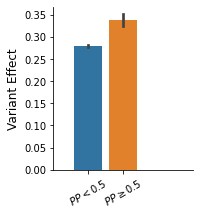

In [27]:
# variant_effect_df['high_pp'] = variant_effect_df['gwas_pp'] >= thresh
plt.figure(figsize=(2.5,3.))
sns.barplot(x='pp_cat',y='absVariantEffect',data=variant_effect_df)
plt.xticks(rotation=30)
plt.xlabel('',fontsize=12)
plt.ylabel('Variant Effect',fontsize=12)
plt.xlim([-1,3])
sns.despine()

plot_dir = '/data/cb/alexwu/mm_finemap/figures'
plt.savefig(os.path.join(plot_dir,'variant_effect','fimo.variant_effect.gwas_pp.pdf'), 
            dpi=500, bbox_inches = "tight")
plt.show()

In [31]:
from scipy.stats import ttest_ind


print(ttest_ind(variant_effect_df[variant_effect_df['pp_cat'] == r'$PP < 0.5$']['absVariantEffect'].values,
                  variant_effect_df[variant_effect_df['pp_cat'] == r'$PP \geq 0.5$']['absVariantEffect'].values,
                  alternative='less',equal_var=False))

# print(ttest_ind(variant_effect_df[variant_effect_df['pp_cat'] == r'$PP < 0.05$']['absVariantEffect'].values,
#                   variant_effect_df[variant_effect_df['pp_cat'] == r'$PP \geq 0.25$']['absVariantEffect'].values,
#                   alternative='less'))

Ttest_indResult(statistic=-8.442048625088692, pvalue=2.5206388389635597e-17)


#### Comparison of TF Binding Affinity Changes: Ours vs. GWAS Variants

In [43]:
len(set(combined_df['variant_orig']) & set(variant_effect_df['pos']))

69

In [77]:
rsid2pos_dict = {rsid: 'chr{}-{}'.format(int(chr_no),int(pos)) for chr_no,pos,rsid 
                 in credible_sets_df[['chromosome','position','rsid']].values if chr_no != 'X'}
index_snp_pos = set([rsid2pos_dict[n] for n in prioritized_df['Index.SNP'] if n in rsid2pos_dict])
gridnet_snp_pos = set(combined_df[combined_df['gwas_pp'] >= 0.1]['variant_orig'])

In [83]:
gwas_prioritized_idx = [i for i,n in enumerate(variant_effect_df['pos']) if n in index_snp_pos]
gridnet_idx = [i for i,n in enumerate(variant_effect_df['pos']) if n in gridnet_snp_pos]


In [84]:
variant_effect_df.iloc[gridnet_idx]['absVariantEffect'].values.mean()

0.3148512257846983

In [85]:
variant_effect_df.iloc[gwas_prioritized_idx]['absVariantEffect'].values.mean()

0.32611400560858017

## Genes Linked to Variants Causing TF Gain/Loss

In [22]:
data_dict = {k: [] for k in ['genes','tf','variantEffect','pos','rsid']}

thresh = 0 #np.log10(40)
for pos in set(inlinks_df[abs(inlinks_df['variantEffect']) > thresh]['pos']):

    # only variants with variantEffect > thresh
    pos_df = inlinks_df[(inlinks_df['pos'] == pos) & (abs(inlinks_df['variantEffect']) > thresh)]
    
    linked_genes = ', '.join(combined_df[combined_df['variant_orig'] == pos]['gene'].values)
    
    for tf,variantEffect in pos_df[['tf','variantEffect']].values:
        data_dict['tf'].append(tf)
        data_dict['variantEffect'].append(variantEffect)
        data_dict['genes'].append(linked_genes)
        data_dict['pos'].append(pos)
        data_dict['rsid'].append(pos2rsid_dict[pos])
        
plot_df = pd.DataFrame(data_dict)
plot_df['absVariantEffect'] = abs(plot_df['variantEffect'])
plot_df = plot_df.sort_values('absVariantEffect',ascending=False)


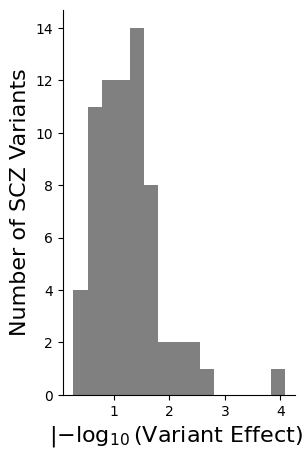

In [18]:
max_effects = plot_df.groupby('rsid').max('absVariantEffect')['absVariantEffect'].values
plt.figure(figsize=(3,5))
plt.hist(max_effects,bins=15,color='grey')
plt.xlabel(r'|$-\log_{10}$' '(Variant Effect)|',fontsize=16)
plt.ylabel('Number of SCZ Variants',fontsize=16)
sns.despine()

plot_dir = '/data/cb/alexwu/mm_finemap/figures'
# plt.savefig(os.path.join(plot_dir,'motifs','fimo.variant_effect.dist.pdf'), dpi=500, bbox_inches = "tight")

plt.show()

In [19]:
(max_effects >= np.log10(10)).sum()

43

In [20]:
data_dict = {k: [] for k in ['genes','tf','variantEffect','pos','rsid']}

thresh = np.log10(20)
for pos in set(inlinks_df[abs(inlinks_df['variantEffect']) > thresh]['pos']):

    # only variants with variantEffect > thresh
    pos_df = inlinks_df[(inlinks_df['pos'] == pos) & (abs(inlinks_df['variantEffect']) > thresh)]
    
    linked_genes = ', '.join(combined_df[combined_df['variant_orig'] == pos]['gene'].values)
    
    for tf,variantEffect in pos_df[['tf','variantEffect']].values:
        data_dict['tf'].append(tf)
        data_dict['variantEffect'].append(variantEffect)
        data_dict['genes'].append(linked_genes)
        data_dict['pos'].append(pos)
        data_dict['rsid'].append(pos2rsid_dict[pos])
        
plot_df = pd.DataFrame(data_dict)
plot_df['absVariantEffect'] = abs(plot_df['variantEffect'])
plot_df['effect'] = ['TF loss' if n < 0 else 'TF gain' for n in plot_df['variantEffect']] 
plot_df['color'] = ['red' if n < 0 else 'blue' for n in plot_df['variantEffect']] 

plot_df['chr'] = [int(n.split('-')[0].strip('chr')) for n in plot_df['pos'].values]
plot_df['bp'] = [int(n.split('-')[1]) for n in plot_df['pos'].values]
# plot_df = plot_df.sort_values(['chr','bp'],ascending=True)

plot_df = plot_df.sort_values('absVariantEffect',ascending=False)


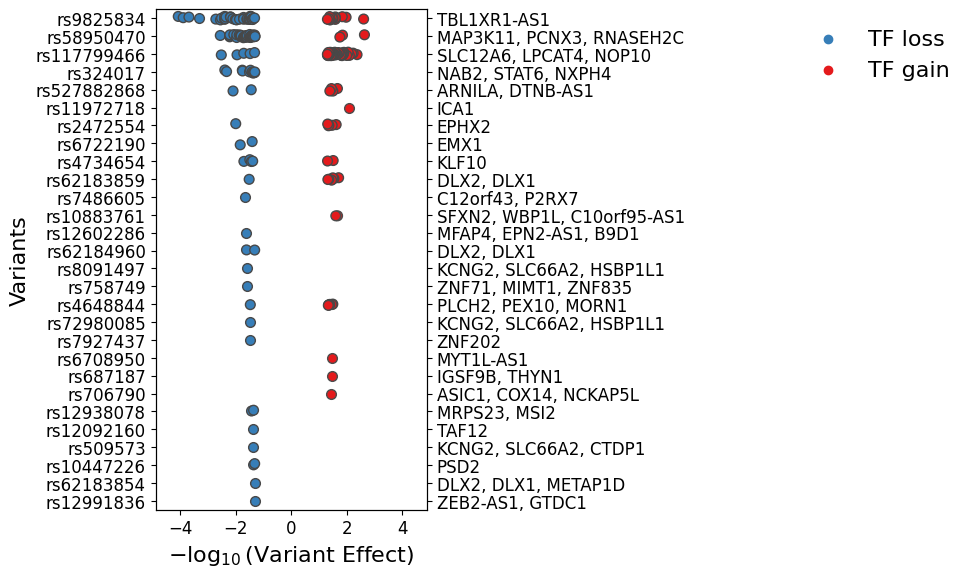

In [21]:
palette = sns.color_palette("Set1", n_colors=2)
palette.reverse()

max_value = abs(plot_df['variantEffect']).max()

fig, ax = plt.subplots(figsize=(3.5,6.5))
sns.stripplot(x='variantEffect',y='rsid',hue='effect',data=plot_df,
              palette=palette,s=7,edgecolors='black',linewidth=1,ax=ax)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xlabel(r'$-\log_{10}$' '(Variant Effect)',fontsize=16)
ax.set_ylabel('Variants',fontsize=16)
ax.set_xlim([-1.2*max_value,1.2*max_value])

ax.legend(title='',fontsize=16,frameon=False,bbox_to_anchor=(3,1))

ax2 = plt.twinx()
ax2.set(yticks=ax.get_yticks(), yticklabels=plot_df.drop_duplicates('rsid')['genes'].values, 
        ylim=ax.get_ylim())# sns.despine()
ax2.tick_params(axis='both', which='major', labelsize=12)

plot_dir = '/data/cb/alexwu/mm_finemap/figures'
# plt.savefig(os.path.join(plot_dir,'motifs','fimo.variant_effect.pdf'), dpi=500, bbox_inches = "tight")
plt.show()

In [23]:
target_genes = pd.DataFrame([n for n in plot_df['genes'].values]).drop_duplicates().values[:,0]
target_genes = [g for n in target_genes for g in n.split(', ')]

for g in target_genes[0:20]:
    print('---------------------------------------')
    print(combined_df[combined_df['gene'] == g][['atac_id','gene','dist','rank','isNearestGene']])

---------------------------------------
     atac_id         gene    dist  rank  isNearestGene
188   110066  TBL1XR1-AS1  3998.0     0           True
---------------------------------------
     atac_id     gene    dist  rank  isNearestGene
370   299026  MAP3K11  2012.0     0          False
---------------------------------------
     atac_id   gene     dist  rank  isNearestGene
371   299026  PCNX3 -13663.0     1           True
---------------------------------------
     atac_id      gene      dist  rank  isNearestGene
372   299026  RNASEH2C -104050.0     2          False
---------------------------------------
     atac_id     gene     dist  rank  isNearestGene
505   367234  SLC12A6  29263.0     0          False
---------------------------------------
     atac_id    gene  dist  rank  isNearestGene
506   367234  LPCAT4  24.0     1           True
---------------------------------------
     atac_id   gene     dist  rank  isNearestGene
507   367234  NOP10  23869.0     2          False


In [24]:
len(set(combined_df['variant_orig'])),len(set(plot_df['pos']))

(115, 28)

In [25]:
len(set(combined_df['variant_orig']) - set(plot_df['pos']))

87

#### Large Variant Effects Across All Variants

In [23]:
# get all GWAS variants (with PP > 0.05) that overlap peak
trait = 'schizophrenia_nature'
finemap_key = 'finemap_posterior_probability'
pp_thresh = 0.05

data_dir = '/data/cb/alexwu/mm_finemap/data/gwas/human_cortex_multiome'
file_name = '{}.credible_sets.txt.gz'.format(trait)

gwas_df = pd.read_csv(os.path.join(data_dir,file_name),sep='\t',compression='gzip')

# filter GWAS variants by p-value
gwas_df = gwas_df[gwas_df[finemap_key] >= pp_thresh]
gwas_df = gwas_df[gwas_df['atac_id'].notna()]
gwas_df['atac_id'] = gwas_df['atac_id'].astype(int)

In [24]:
print('# of variants overlapping peaks in data:', len(set(gwas_df['rsid'])))

# of variants overlapping peaks in data: 195


In [25]:
thresh = np.log10(20)

print('# of variants overlapping peaks in data w/ large change in TF binding affinity')
len(set([int(n.split('-')[1]) for n in data_df[abs(data_df['variantEffect']) > thresh]['pos'].values]) 
    & set(gwas_df['position']))

# of variants overlapping peaks in data w/ large change in TF binding affinity


41

In [26]:
data_dict = {k: [] for k in ['genes','tf','variantEffect','pos','rsid']}

thresh = np.log10(20)
for pos in set(data_df[abs(data_df['variantEffect']) > thresh]['pos']):

    # only variants with variantEffect > thresh
    pos_df = data_df[(data_df['pos'] == pos) & (abs(data_df['variantEffect']) > thresh)]
    
    linked_genes = ', '.join(combined_df[combined_df['variant_orig'] == pos]['gene'].values)
    
    for tf,variantEffect in pos_df[['tf','variantEffect']].values:
        data_dict['tf'].append(tf)
        data_dict['variantEffect'].append(variantEffect)
        data_dict['genes'].append(linked_genes)
        data_dict['pos'].append(pos)
        data_dict['rsid'].append(pos2rsid_dict[pos])
        
plot_df = pd.DataFrame(data_dict)


len(set(combined_df['variant_orig'])),len(set(plot_df['pos']))

(115, 397)

### TF Motifs Gained/Lost

In [30]:
# drop duplicates of TFs per variant
df_list = []
for (tf,pos),group_df in inlinks_df.groupby(['tf','pos']):
    df_list.append(group_df.iloc[[np.argmax(abs(group_df['variantEffect']))]])
max_effect_df = pd.concat(df_list)

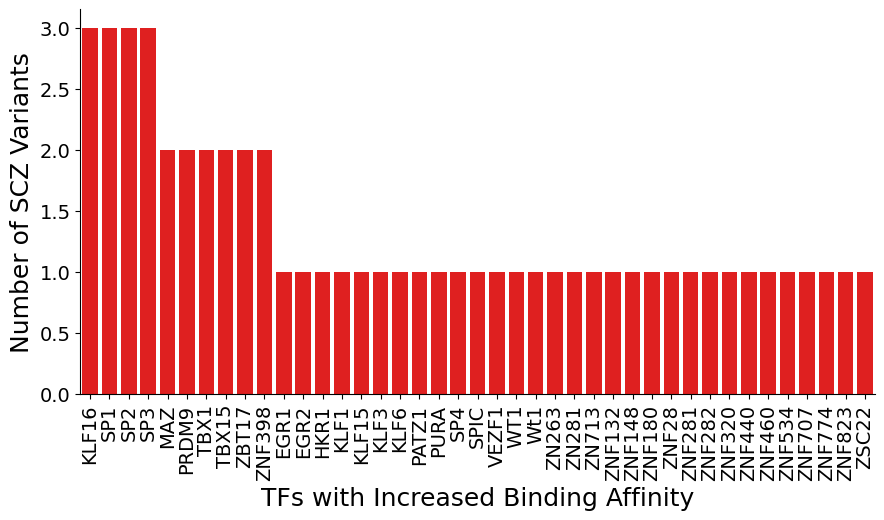

In [31]:
# gained
thresh = np.log10(20)
counts = Counter(max_effect_df[max_effect_df['variantEffect'] > thresh]['tf'])

df = pd.DataFrame(np.array(counts.most_common()),columns=['gene','count'])
df['count'] = df['count'].astype(int)

plt.figure(figsize=(df.shape[0]/4,5))
sns.barplot(x='gene',y='count',data=df,color='red')
plt.xticks(rotation=90,fontsize=14)
plt.yticks(fontsize=14)

plt.xlabel('TFs with Increased Binding Affinity',fontsize=18)
plt.ylabel('Number of SCZ Variants',fontsize=18)
sns.despine()

plot_dir = '/data/cb/alexwu/mm_finemap/figures'
# plt.savefig(os.path.join(plot_dir,'motifs','fimo.tf_gain.pdf'), dpi=500, bbox_inches = "tight")

plt.show()

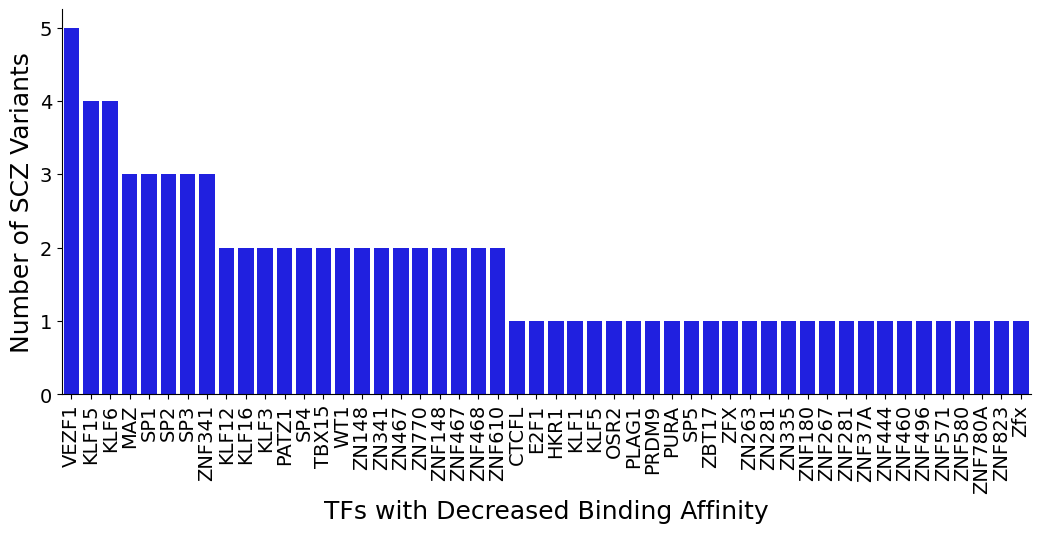

In [32]:
# lost
thresh = np.log10(20)
counts = Counter(max_effect_df[max_effect_df['variantEffect'] < -thresh]['tf'])

df = pd.DataFrame(np.array(counts.most_common()),columns=['gene','count'])
df['count'] = df['count'].astype(int)

plt.figure(figsize=(df.shape[0]/4,5))
sns.barplot(x='gene',y='count',data=df,color='blue')
plt.xticks(rotation=90,fontsize=14)
plt.yticks(fontsize=14)
sns.despine()
plt.xlabel('TFs with Decreased Binding Affinity',fontsize=18)
plt.ylabel('Number of SCZ Variants',fontsize=18)

plot_dir = '/data/cb/alexwu/mm_finemap/figures'
# plt.savefig(os.path.join(plot_dir,'motifs','fimo.tf_loss.pdf'), dpi=500, bbox_inches = "tight")

plt.show()

### TF Binding Affinity Change vs. Target Genes

In [65]:
thresh = np.log10(20)
for pos in set(inlinks_df[abs(inlinks_df['variantEffect']) > thresh]['pos']):
    print('*****',gwas_df[gwas_df['position'] == int(pos.split('-')[1])][['rsid','impact']].values,'*****')
    print('--------------------------------')
    pos_df = inlinks_df[(inlinks_df['pos'] == pos) & (abs(inlinks_df['variantEffect']) > thresh)]
    
    print(pos_df[['tf','variantEffect']].groupby('tf').max().sort_values('variantEffect'))
    print('-----------------------------------------------------------------------')
    print(combined_df[combined_df['variant_orig'] == pos][['variant_orig','atac_id','gene','rank',score_key,'abs_dist','gwas_pp','isNearestGene','nearest_gene']])
    
    print('-----------------------------------------------------------------------')
    print('-----------------------------------------------------------------------\n\n')
    

***** [['rs2472554' 'intron_variant']] *****
--------------------------------
        variantEffect
tf                   
KLF6        -2.004208
ZBT17        1.314125
ZNF398       1.345411
MAZ          1.354589
ZNF132       1.475882
KLF16        1.619689
-----------------------------------------------------------------------
      variant_orig  atac_id   gene  rank  graph.ranks.mean-LR-dist  abs_dist  \
259  chr8-27328354   225237  EPHX2     0                  0.560356   44477.0   

     gwas_pp  isNearestGene nearest_gene  
259    0.134          False       CHRNA2  
-----------------------------------------------------------------------
-----------------------------------------------------------------------


***** [['rs62183859' 'upstream_gene_variant']] *****
--------------------------------
        variantEffect
tf                   
KLF15       -1.519643
SP1          1.354506
ZNF180       1.455626
KLF16        1.500165
SP3          1.538440
SP2          1.708357
-------------------

### Cell Type Gene Expression

In [32]:
thresh = np.log10(20)
gene_list = []
for pos in set(inlinks_df[abs(inlinks_df['variantEffect']) > thresh]['pos']):
    gene_list.extend(combined_df[combined_df['variant_orig'] == pos]['gene'].values)
gene_list = list(set(gene_list))

In [33]:
rna_adata.obs['cell_type_broad'] = [n[:-1] if 'GluN' in n else n for n in rna_adata.obs['cell_type']]

trait = 'schizophrenia_nature'
combined_df = combined_df_dict[trait].copy()
disease_genes = sorted(list(set(combined_df['gene'])))

cell_type_list = sorted(list(set(rna_adata.obs['cell_type_broad'])))

X_list = []
for cell_type in cell_type_list:
    X_list.append(rna_adata[rna_adata.obs['cell_type_broad'] == cell_type][:,gene_list].X.toarray().mean(0))
X = np.array(X_list)

from sklearn.preprocessing import normalize

X = normalize(X,norm='max',axis=0)

exp_df = pd.DataFrame(X,index=cell_type_list,columns=gene_list)

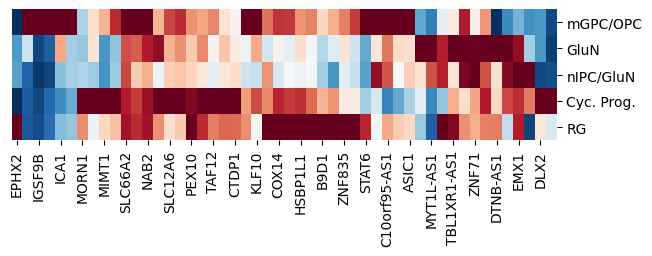

In [34]:
cg = sns.clustermap(exp_df,figsize=(8,3),cmap='RdBu_r')
# plt.xticks(rotation=30)
# plt.setp(cg.ax_heatmap.xaxis.get_majorticklabels()) #, rotation=45)
cg.ax_row_dendrogram.set_visible(False)
cg.ax_col_dendrogram.set_visible(False)
cg.cax.set_visible(False)
plt.show()

#### Disease Genes that are TFs

In [35]:
human_tfs = pd.read_csv('/data/cb/alexwu/general/Homo_sapiens_TF.txt',sep='\t')['Symbol'].values

set(human_tfs) & set(gene_list)

{'DLX1',
 'DLX2',
 'EMX1',
 'KLF10',
 'STAT6',
 'THYN1',
 'ZNF202',
 'ZNF71',
 'ZNF835'}

#### Number of Disease Genes with FIMO Support that are Cell Type-Specific

In [36]:
# general differentially expressed disease genes
disease_rna_adata = rna_adata[:,disease_genes].copy()

sc.tl.rank_genes_groups(disease_rna_adata,groupby='cell_type_broad',method='t-test') #,reference='Cyc. Prog.')

pvals = disease_rna_adata.uns['rank_genes_groups']['pvals']
pvals_adj = disease_rna_adata.uns['rank_genes_groups']['pvals_adj']
lfc = disease_rna_adata.uns['rank_genes_groups']['logfoldchanges']
gene_names = disease_rna_adata.uns['rank_genes_groups']['names']

all_de_genes = []
for cell_type in set(disease_rna_adata.obs['cell_type_broad']):
    all_de_genes.extend(gene_names[cell_type][(pvals_adj[cell_type] < 0.05)]) # & (abs(lfc[cell_type]) > 1)])
all_de_genes = set(all_de_genes)

print(len(all_de_genes),len(disease_genes))

104 132


In [37]:
# general differentially expressed disease genes
disease_rna_adata = rna_adata[:,gene_list].copy()

sc.tl.rank_genes_groups(disease_rna_adata,groupby='cell_type_broad',method='t-test') #,reference='Cyc. Prog.')

pvals = disease_rna_adata.uns['rank_genes_groups']['pvals']
pvals_adj = disease_rna_adata.uns['rank_genes_groups']['pvals_adj']
lfc = disease_rna_adata.uns['rank_genes_groups']['logfoldchanges']
gene_names = disease_rna_adata.uns['rank_genes_groups']['names']

all_de_genes = []
for cell_type in set(disease_rna_adata.obs['cell_type_broad']):
    all_de_genes.extend(gene_names[cell_type][(pvals_adj[cell_type] < 0.05)]) # & (abs(lfc[cell_type]) > 1)])
all_de_genes = set(all_de_genes)

print(len(all_de_genes),len(gene_list))

40 50


In [38]:
set(gene_list)-all_de_genes

{'C12orf43',
 'CTDP1',
 'HSBP1L1',
 'KCNG2',
 'MIMT1',
 'MRPS23',
 'SFXN2',
 'SLC66A2',
 'ZNF202',
 'ZNF835'}

#### TFs

In [40]:
thresh = np.log10(20)

tf_list = []
for pos in set(inlinks_df[abs(inlinks_df['variantEffect']) > thresh]['pos']):
#     print(inlinks_df[(inlinks_df['pos'] == pos) & (abs(inlinks_df['variantEffect']) > thresh)]['tf'].values)
    tfs = inlinks_df[(inlinks_df['pos'] == pos) & (abs(inlinks_df['variantEffect']) > thresh)]['tf'].values
    tf_list.extend(list(set(tfs))) # don't double count TFs per variant

for tf,count in Counter(tf_list).most_common():
    print(tf,'\t',count)
        
# ZN->ZNF
tf_list.extend(['ZNF{}'.format(n.split('ZN')[1]) for n in tf_list 
                if n[0:2] == 'ZN' and 'ZNF' not in n and 'ZNF{}'.format(n.split('ZN')[1]) in rna_adata.var.index.values])

tf_list = list(set(tf_list) & set(rna_adata.var.index.values))

SP1 	 6
SP2 	 6
SP3 	 6
VEZF1 	 6
KLF6 	 5
MAZ 	 5
KLF16 	 5
KLF15 	 5
TBX15 	 4
ZBT17 	 3
ZNF341 	 3
KLF3 	 3
PATZ1 	 3
ZNF148 	 3
WT1 	 3
PRDM9 	 3
SP4 	 3
ZNF398 	 2
ZNF180 	 2
ZNF467 	 2
ZN263 	 2
ZNF460 	 2
ZN148 	 2
ZN341 	 2
ZNF468 	 2
KLF12 	 2
ZN467 	 2
KLF1 	 2
ZNF610 	 2
ZN770 	 2
PURA 	 2
HKR1 	 2
ZN281 	 2
ZNF281 	 2
ZNF823 	 2
TBX1 	 2
ZNF132 	 1
ZNF267 	 1
ZNF37A 	 1
ZNF707 	 1
E2F1 	 1
CTCFL 	 1
PLAG1 	 1
ZNF534 	 1
ZFX 	 1
Zfx 	 1
ZNF496 	 1
ZNF780A 	 1
ZN335 	 1
ZNF282 	 1
ZNF320 	 1
SP5 	 1
ZNF444 	 1
KLF5 	 1
ZNF571 	 1
ZN713 	 1
SPIC 	 1
ZNF28 	 1
ZNF580 	 1
ZNF440 	 1
ZSC22 	 1
OSR2 	 1
EGR1 	 1
ZNF774 	 1
EGR2 	 1
Wt1 	 1


In [41]:
rna_adata.obs['cell_type_broad'] = [n[:-1] if 'GluN' in n else n for n in rna_adata.obs['cell_type']]

# trait = 'schizophrenia_nature'
# combined_df = combined_df_dict[trait].copy()
# disease_genes = sorted(list(set(combined_df['gene'])))

cell_type_list = sorted(list(set(rna_adata.obs['cell_type_broad'])))

X_list = []
for cell_type in cell_type_list:
    X_list.append(rna_adata[rna_adata.obs['cell_type_broad'] == cell_type][:,tf_list].X.toarray().mean(0))
X = np.array(X_list)

from sklearn.preprocessing import normalize

X = normalize(X,norm='max',axis=0)

exp_df = pd.DataFrame(X,index=cell_type_list,columns=tf_list)
exp_df = exp_df[[n for n in exp_df.columns if n != 'OSR2']]

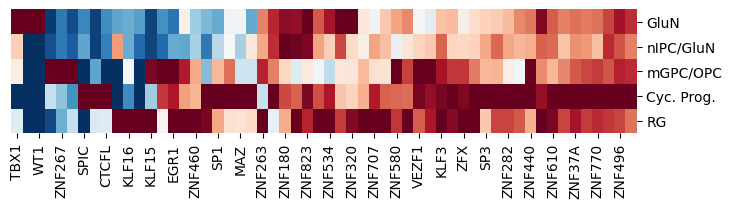

In [42]:
cg = sns.clustermap(exp_df,figsize=(9,2.5),cmap='RdBu_r') #,cmap='coolwarm')
# plt.xticks(rotation=30)
# plt.setp(cg.ax_heatmap.xaxis.get_majorticklabels()) #, rotation=45)
cg.ax_row_dendrogram.set_visible(False)
cg.ax_col_dendrogram.set_visible(False)
cg.cax.set_visible(False)
plt.show()

In [43]:
tf_rna_adata = rna_adata[:,tf_list].copy()

sc.tl.rank_genes_groups(tf_rna_adata,groupby='cell_type_broad',method='t-test') #,reference='Cyc. Prog.')

pvals_adj = tf_rna_adata.uns['rank_genes_groups']['pvals_adj']
lfc = tf_rna_adata.uns['rank_genes_groups']['logfoldchanges']
gene_names = tf_rna_adata.uns['rank_genes_groups']['names']

all_de_genes = []
for cell_type in set(tf_rna_adata.obs['cell_type_broad']):
    all_de_genes.extend(gene_names[cell_type][(pvals_adj[cell_type] < 0.05)]) # & (abs(lfc[cell_type]) > 1)])
all_de_genes = set(all_de_genes)
print(len(all_de_genes),len(tf_list))

33 57


#### TFs that are also disease genes

In [44]:
set(tf_list) & set(combined_df['gene'])

{'ZNF707', 'ZNF823'}

## Compare Genes with FIMO Support to Differentially Expressed SCZ Genes

In [45]:
# thresh = np.log10(40)
# gene_list = []
# for pos in set(inlinks_df[abs(inlinks_df['variantEffect']) > thresh]['pos']):
#     gene_list.extend(combined_df[combined_df['variant_orig'] == pos]['gene'].values)
# gene_list = list(set(gene_list))

In [40]:
from anndata import AnnData

data_dir = '/data/cb/alexwu/mm_finemap/data/gwas/human_cortex_multiome/GoldmanetalSCZ2016/'

data_df = pd.read_csv(os.path.join(data_dir,'countData_allSamples.txt'),sep='\t')

adata = AnnData(data_df.T)
adata.obs['condition'] = ['control' if 'CTR' in n else 'SCZ' for n in adata.obs.index.values]
adata.obs['sample'] = [n[:-1] for n in adata.obs.index.values]
adata.obs['sample_group_ctr'] = [n[:-1] if 'SCZ' in n else 'CTR' for n in adata.obs.index.values]

sc.pp.normalize_total(adata,target_sum=1e6)
sc.pp.log1p(adata)

/tmp/ipykernel_423513/2986422355.py:7: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = AnnData(data_df.T)


In [41]:
across_samples = True

if across_samples:
    disease_adata = adata[:,[n for n in gene_list if n in adata.var.index.values]].copy()
    sc.tl.rank_genes_groups(disease_adata,groupby='sample_group_ctr',method='t-test_overestim_var',reference='CTR')

    gene_names = np.array([disease_adata.uns['rank_genes_groups']['names'][k] for k 
                      in sorted(list(set(adata.obs['sample_group_ctr']))) if k != 'CTR'])
    pvals = np.array([disease_adata.uns['rank_genes_groups']['pvals'][k] for k 
                      in sorted(list(set(adata.obs['sample_group_ctr']))) if k != 'CTR'])
    pvals_adj = np.array([disease_adata.uns['rank_genes_groups']['pvals_adj'][k] for k 
                      in sorted(list(set(adata.obs['sample_group_ctr']))) if k != 'CTR'])
    lfc = np.array([disease_adata.uns['rank_genes_groups']['logfoldchanges'][k] for k 
                      in sorted(list(set(adata.obs['sample_group_ctr']))) if k != 'CTR'])
    
    sorted_gene_inds = np.argsort(gene_names,axis=1)
    gene_names = np.take_along_axis(gene_names,sorted_gene_inds,axis=1)
    pvals = np.take_along_axis(pvals,sorted_gene_inds,axis=1)
    pvals_adj = np.take_along_axis(pvals_adj,sorted_gene_inds,axis=1)
    lfc = np.take_along_axis(lfc,sorted_gene_inds,axis=1)
    
    argmin = np.argmin(pvals,axis=0).copy()
    pvals = np.take_along_axis(pvals,argmin[None],axis=0).squeeze()
    pvals_adj = np.take_along_axis(pvals_adj,argmin[None],axis=0).squeeze()
    lfc = np.take_along_axis(lfc,argmin[None],axis=0).squeeze()
    gene_names = gene_names[0]
    
else:
    
    disease_adata = adata[:,[n for n in gene_list if n in adata.var.index.values]]
    sc.tl.rank_genes_groups(disease_adata,groupby='condition',method='t-test_overestim_var',reference='control')

    pvals = disease_adata.uns['rank_genes_groups']['pvals']['SCZ']
    pvals_adj = disease_adata.uns['rank_genes_groups']['pvals_adj']['SCZ']
    lfc = disease_adata.uns['rank_genes_groups']['logfoldchanges']['SCZ']
    gene_names = disease_adata.uns['rank_genes_groups']['names']['SCZ']

    up_genes = gene_names[(lfc > 0) & (pvals < 0.05)]
    down_genes = gene_names[(lfc < 0) & (pvals < 0.05)]

    print(len(up_genes),len(down_genes))

### Correlation b/w FIMO Score Changes vs. Differential Expression

In [42]:
# determine glial-specific genes
disease_rna_adata = rna_adata[:,disease_genes].copy()

sc.tl.rank_genes_groups(disease_rna_adata,groupby='cell_type_broad',
                        method='t-test',reference='Cyc. Prog.')

pvals = disease_rna_adata.uns['rank_genes_groups']['pvals']
pvals_adj = disease_rna_adata.uns['rank_genes_groups']['pvals_adj']
lfc = disease_rna_adata.uns['rank_genes_groups']['logfoldchanges']
gene_names = disease_rna_adata.uns['rank_genes_groups']['names']

glial_de_genes = gene_names['RG'][(pvals['RG'] < 0.05)]
print(len(glial_de_genes))

38


In [43]:
across_samples = True

if across_samples:
    filtered_adata = adata[:,list(set(eval_df['gene']) & set(adata.var.index.values))].copy()

    sc.tl.rank_genes_groups(filtered_adata,groupby='sample_group_ctr',method='t-test',reference='CTR')

    gene_names = np.array([filtered_adata.uns['rank_genes_groups']['names'][k] for k 
                      in sorted(list(set(adata.obs['sample_group_ctr']))) if k != 'CTR'])
    pvals = np.array([filtered_adata.uns['rank_genes_groups']['pvals'][k] for k 
                      in sorted(list(set(adata.obs['sample_group_ctr']))) if k != 'CTR'])
    pvals_adj = np.array([filtered_adata.uns['rank_genes_groups']['pvals_adj'][k] for k 
                      in sorted(list(set(adata.obs['sample_group_ctr']))) if k != 'CTR'])
    lfc = np.array([filtered_adata.uns['rank_genes_groups']['logfoldchanges'][k] for k 
                      in sorted(list(set(adata.obs['sample_group_ctr']))) if k != 'CTR'])
    
    # rearrange in same gene order
    sorted_gene_inds = np.argsort(gene_names,axis=1)
    gene_names = np.take_along_axis(gene_names,sorted_gene_inds,axis=1)
    pvals = np.take_along_axis(pvals,sorted_gene_inds,axis=1)
    pvals_adj = np.take_along_axis(pvals_adj,sorted_gene_inds,axis=1)
    lfc = np.take_along_axis(lfc,sorted_gene_inds,axis=1)

    # take mean
    pvals = np.exp(-(-np.log10(pvals).mean(0)))
    pvals_adj = pvals_adj.mean(0)
    lfc = lfc.mean(0)
    gene_names = gene_names[0]
    
else:
    filtered_adata = adata[:,list(set(eval_df['gene']) & set(adata.var.index.values))].copy()
    sc.tl.rank_genes_groups(adata,groupby='condition',method='t-test',reference='control')

    pvals = adata.uns['rank_genes_groups']['pvals']['SCZ']
    pvals_adj = adata.uns['rank_genes_groups']['pvals_adj']['SCZ']
    lfc = adata.uns['rank_genes_groups']['logfoldchanges']['SCZ']
    gene_names = adata.uns['rank_genes_groups']['names']['SCZ']

    print(gene_names)

In [44]:
data_dict = {k: [] for k in ['pos','atac_id','fimo_change','gene','de_p','de_lfc']}

for pos in set(inlinks_df['pos']):
    
    fimo_change = abs(inlinks_df[inlinks_df['pos'] == pos]['variantEffect']).max()

    # relevant peak
    atac_id = combined_df[(combined_df['variant_orig'] == pos)]['atac_id'].values[0]
    
    # nearest gene
    linked_genes = combined_df[(combined_df['variant_orig'] == pos) & (combined_df['rank'] == 0)]['gene'].values
    nearest_gene = combined_df[combined_df['variant_orig'] == pos]['nearest_gene'].values[0]
    
    for g in linked_genes:
        if g in set(adata.var.index.values) and g in glial_de_genes: # and g == nearest_gene:
            data_dict['pos'].append(pos)
            data_dict['atac_id'].append(atac_id)
            data_dict['fimo_change'].append(fimo_change)
            data_dict['gene'].append(g)
            data_dict['de_p'].append(pvals[gene_names == g][0])
            data_dict['de_lfc'].append(lfc[gene_names == g][0])
results_df = pd.DataFrame(data_dict)
results_df['-log_de_p'] = -np.log10(results_df['de_p'])
results_df['abs_de_lfc'] = abs(results_df['de_lfc'])

results_df['is_de'] = results_df['de_p'] < 0.05
print(results_df['is_de'].mean())


0.0


In [45]:
# add/average expression changes for all genes linked to a variant
results_df = results_df.groupby(['gene']).max().reset_index()


In [46]:
from scipy.stats import spearmanr,pearsonr

print(pearsonr(results_df['fimo_change'],results_df['-log_de_p']))

PearsonRResult(statistic=0.5850908615862869, pvalue=0.021951528892407066)


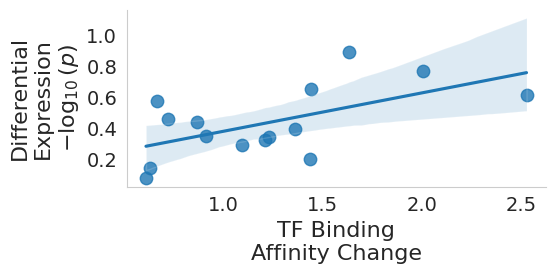

In [47]:
sns.set_style("whitegrid", {'axes.grid' : False})

sns.lmplot(x='fimo_change',y='-log_de_p',data=results_df,height=2.5,aspect=2,
           scatter_kws={"s": 80},palette="#69d")

plt.xlabel('TF Binding\nAffinity Change',fontsize=16)
plt.ylabel('Differential\nExpression\n' r'$-\log_{10}(p)$',fontsize=16)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.locator_params(axis='x',nbins=5)

sns.despine()

plot_dir = '/data/cb/alexwu/mm_finemap/figures'
# plt.savefig(os.path.join(plot_dir,'motifs','fimo.variant_effect_de_correlation.pdf'), dpi=500, bbox_inches = "tight")
plt.show()

In [48]:
results_df[results_df['de_p'] < 0.3]

,gene,pos,atac_id,fimo_change,de_p,de_lfc,-log_de_p,abs_de_lfc,is_de
0,ASIC1,chr12-50464470,320649,1.443640,0.219927,-0.897463,0.657721,0.897463,False
3,CYB561,chr17-61556298,408136,0.666899,0.262645,-0.257311,0.580630,0.257311,False
5,EPHX2,chr8-27328354,225237,2.004208,0.169368,-0.484798,0.771168,0.484798,False
7,MFAP4,chr17-19236954,399947,1.632593,0.127521,-0.572708,0.894417,0.572708,False
13,SLC12A6,chr15-34659517,367234,2.525329,0.241376,-0.216839,0.617306,0.216839,False


In [50]:
results_df[results_df['fimo_change'] > 1.]

,gene,pos,atac_id,fimo_change,de_p,de_lfc,-log_de_p,abs_de_lfc,is_de
0,ASIC1,chr12-50464470,320649,1.443640,0.219927,-0.897463,0.657721,0.897463,False
1,BNIP3L,chr8-26250047,224921,1.233712,0.447877,0.111805,0.348842,0.111805,False
2,C9orf129,chr9-96253178,254219,1.096167,0.510028,0.146461,0.292406,0.146461,False
4,ELAC2,chr17-12896553,398790,1.209571,0.471046,-0.172486,0.326937,0.172486,False
5,EPHX2,chr8-27328354,225237,2.004208,0.169368,-0.484798,0.771168,0.484798,False
7,MFAP4,chr17-19236954,399947,1.632593,0.127521,-0.572708,0.894417,0.572708,False
8,MRPS23,chr17-55743277,407178,1.435367,0.625323,-0.146301,0.203895,0.146301,False
10,PSD2,chr5-139065180,158638,1.361028,0.400609,-0.546818,0.397279,0.546818,False
13,SLC12A6,chr15-34659517,367234,2.525329,0.241376,-0.216839,0.617306,0.216839,False


In [55]:
# for atac_id in results_df[results_df['fimo_change'] > 1.5]['atac_id']:
#     print(combined_df[combined_df['atac_id'] == atac_id][['atac_id','gene','abs_dist',score_key,'gwas_pp','nearest_gene']])

## Disease Genes: Correlation Pathways

In [91]:
from scipy.stats import spearmanr,pearsonr
from collections import Counter

filtered_adata = adata[:,list(set(eval_df['gene']) & set(adata.var.index.values))].copy()

for corr_thresh in [0.8,0.85,0.9][0:1]:
    print(corr_thresh)
    
    corr_dict = {}
    for g in gene_list:
        if g in filtered_adata.var.index.values:
            gene1_exp = adata[:,g].X.squeeze()
            corr_values = np.array([pearsonr(gene1_exp,filtered_adata.X[:,i].squeeze())[0] 
                                    for i in range(filtered_adata.shape[1])])

            corr_dict[g] = (filtered_adata.var.index.values[abs(corr_values) > corr_thresh],
                            corr_values[abs(corr_values) > corr_thresh])
            
    all_pathway_genes = []
    for g,(corr_genes,corr_values) in corr_dict.items():
        all_pathway_genes.extend(corr_genes)
    
    # write to file
    save_dir = '/data/cb/alexwu/mm_finemap/results/gwas/disease_genes_correlation'
    df = pd.DataFrame(np.array([[g,';'.join(corr_genes),';'.join(map(str,corr_values))] 
                       for g,(corr_genes,corr_values) in corr_dict.items()]))
    df.columns = ['disease_gene','correlated_genes','correlations']
    
    df.to_csv(os.path.join(save_dir,'corr_thresh{}.new.csv'.format(corr_thresh)),sep='\t')

0.8


### Correlated Genes

In [84]:
corr_thresh = 0.8

save_dir = '/data/cb/alexwu/mm_finemap/results/gwas/disease_genes_correlation'
corr_df = pd.read_csv(os.path.join(save_dir,'corr_thresh{}.csv'.format(corr_thresh)),sep='\t')
corr_df.index = corr_df['disease_gene'].values

for disease_gene,corr_genes in corr_df[['disease_gene','correlated_genes']].values:
    print(disease_gene,len(corr_genes.split(';')))
    
all_pathway_genes = [g for n in corr_df['correlated_genes'].values for g in n.split(';')]

print('------------')
Counter(all_pathway_genes).most_common(15)

B9D1 15
P2RX7 66
NAB2 2
KLF10 1
NOP10 77
C12orf43 3
LPCAT4 84
WBP1L 5
RNASEH2C 1
SFXN2 2
EPN2-AS1 4
SLC12A6 439
ICA1 86
MAP3K11 2
STAT6 349
NXPH4 131
DLX1 76
MFAP4 300
DLX2 70
EPHX2 5
EMX1 1
------------


[('DCLK2', 5),
 ('GPX8', 4),
 ('CCDC112', 4),
 ('SMARCD1', 4),
 ('RNF38', 4),
 ('DPYSL3', 4),
 ('RIMKLA', 4),
 ('ZBTB18', 4),
 ('PFN2', 4),
 ('WDR47', 4),
 ('TUBB3', 4),
 ('FNBP1L', 3),
 ('CDH11', 3),
 ('TMEM214', 3),
 ('FKBP10', 3)]

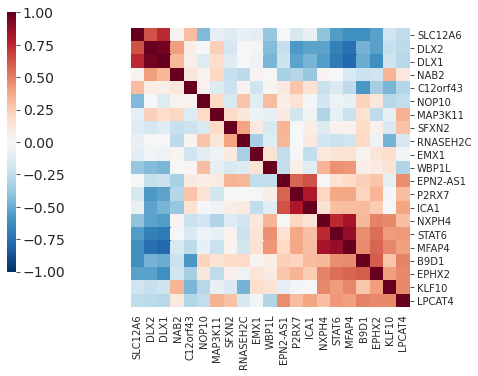

In [94]:
exp_gene_list = [n for n in gene_list if n in adata.var.index.values]

exp_corr_df = pd.DataFrame(spearmanr(adata[:,exp_gene_list].X)[0],
                           index=exp_gene_list,columns=exp_gene_list)

fg = sns.clustermap(exp_corr_df,figsize=(6,6),vmin=-1,vmax=1,cmap='RdBu_r')
fg.ax_cbar.set_position([-0.1, 0.25, 0.02, 0.6])
# fg.ax_cbar.set_title('Spearman\nCorrelation')
fg.ax_cbar.tick_params(labelsize=14)
fg.ax_row_dendrogram.set_visible(False)
fg.ax_col_dendrogram.set_visible(False)

plot_dir = '/data/cb/alexwu/mm_finemap/figures'
# plt.savefig(os.path.join(plot_dir,'motifs','linked_genes.heatmap.pdf'), dpi=500, bbox_inches = "tight")

plt.show()

In [86]:
module_disease_genes = []
for i,j in zip(*np.where(exp_corr_df.values > 0.6)):
    if i != j:
        print(exp_corr_df.columns[[i,j]])
        module_disease_genes.extend(exp_corr_df.columns[[i,j]])
        
print(set(module_disease_genes))

Index(['P2RX7', 'ICA1'], dtype='object')
Index(['EPN2-AS1', 'ICA1'], dtype='object')
Index(['B9D1', 'EPHX2'], dtype='object')
Index(['STAT6', 'MFAP4'], dtype='object')
Index(['STAT6', 'NXPH4'], dtype='object')
Index(['DLX2', 'DLX1'], dtype='object')
Index(['DLX2', 'SLC12A6'], dtype='object')
Index(['MFAP4', 'STAT6'], dtype='object')
Index(['MFAP4', 'NXPH4'], dtype='object')
Index(['DLX1', 'DLX2'], dtype='object')
Index(['DLX1', 'SLC12A6'], dtype='object')
Index(['EPHX2', 'B9D1'], dtype='object')
Index(['SLC12A6', 'DLX2'], dtype='object')
Index(['SLC12A6', 'DLX1'], dtype='object')
Index(['NXPH4', 'STAT6'], dtype='object')
Index(['NXPH4', 'MFAP4'], dtype='object')
Index(['ICA1', 'P2RX7'], dtype='object')
Index(['ICA1', 'EPN2-AS1'], dtype='object')
{'DLX1', 'EPHX2', 'MFAP4', 'DLX2', 'ICA1', 'P2RX7', 'EPN2-AS1', 'B9D1', 'SLC12A6', 'NXPH4', 'STAT6'}


9


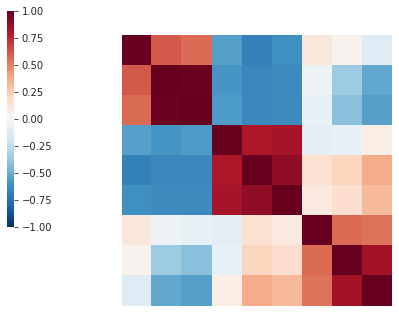

In [88]:
genes2use = [['SLC12A6','DLX1','DLX2'],['NXPH4','STAT6','MFAP4'],['EPN2-AS1','P2RX7','ICA1']]
genes2use = [n for k in genes2use for n in k]

genes2use = exp_corr_df.columns[(abs(exp_corr_df.loc[genes2use]) >= 0.8).sum(0).values > 0]

from scipy.stats import spearmanr

sorted_pathway_genes = sorted(list(set(genes2use)))
print(len(sorted_pathway_genes))

exp_corr_df = pd.DataFrame(np.corrcoef(adata[:,sorted_pathway_genes].X.T),
                           index=sorted_pathway_genes,columns=sorted_pathway_genes)

fg = sns.clustermap(exp_corr_df,vmin=-1,vmax=1,cmap='RdBu_r',figsize=(5,5),
                   xticklabels=False,yticklabels=False)
fg.ax_cbar.set_position([-0.1, 0.25, 0.02, 0.6])
# fg.ax_cbar.set_title('Spearman\nCorrelation')
# fg.ax_cbar.tick_params(labelsize=14)
# fg.ax_heatmap.tick_params(right=False,bottom=False)
fg.ax_row_dendrogram.set_visible(False)
fg.ax_col_dendrogram.set_visible(False)
reordered_inds = fg.dendrogram_col.reordered_ind

plot_dir = '/data/cb/alexwu/mm_finemap/figures'
# plt.savefig(os.path.join(plot_dir,'motifs','pathway_genes.heatmap.new.pdf'), bbox_inches = "tight")

plt.show()

9


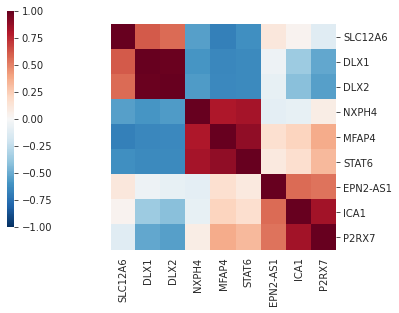

In [93]:
genes2use = [['SLC12A6','DLX1','DLX2'],['NXPH4','STAT6','MFAP4'],['EPN2-AS1','P2RX7','ICA1']]
genes2use = [n for k in genes2use for n in k]

genes2use = exp_corr_df.columns[(abs(exp_corr_df.loc[genes2use]) >= 0.8).sum(0).values > 0]

from scipy.stats import spearmanr

sorted_pathway_genes = sorted(list(set(genes2use)))
print(len(sorted_pathway_genes))

exp_corr_df = pd.DataFrame(np.corrcoef(adata[:,sorted_pathway_genes].X.T),
                           index=sorted_pathway_genes,columns=sorted_pathway_genes)

fg = sns.clustermap(exp_corr_df,vmin=-1,vmax=1,cmap='RdBu_r',figsize=(5,5),)
#                    xticklabels=False,yticklabels=False)
fg.ax_cbar.set_position([-0.1, 0.25, 0.02, 0.6])
# fg.ax_cbar.set_title('Spearman\nCorrelation')
# fg.ax_cbar.tick_params(labelsize=14)
# fg.ax_heatmap.tick_params(right=False,bottom=False)
fg.ax_row_dendrogram.set_visible(False)
fg.ax_col_dendrogram.set_visible(False)
reordered_inds = fg.dendrogram_col.reordered_ind

plot_dir = '/data/cb/alexwu/mm_finemap/figures'
# plt.savefig(os.path.join(plot_dir,'motifs','pathway_genes.heatmap.pdf'), dpi=500, bbox_inches = "tight")

plt.show()

In [131]:
import networkx as nx

G = nx.from_numpy_matrix(exp_corr_df.values > 0.9)

for c in nx.connected_components(G):
    overlap_genes = set(np.array(sorted_pathway_genes)[list(c)]) & set(gene_list)
    if len(overlap_genes):
        print(overlap_genes)

{'STAT6', 'NXPH4', 'MFAP4'}
{'DLX2', 'DLX1', 'SLC12A6'}
{'LPCAT4'}
{'P2RX7', 'ICA1'}
{'B9D1'}
{'NOP10'}
{'C12orf43'}
{'EMX1'}
{'EPHX2'}
{'EPN2-AS1'}
{'KLF10'}
{'MAP3K11'}
{'NAB2'}
{'RNASEH2C'}
{'SFXN2'}
{'WBP1L'}


In [91]:
set(exp_corr_df.loc['DLX2'][exp_corr_df.loc['DLX2'] > 0.5].index.values) & set(gene_list)

{'DLX1', 'DLX2', 'SLC12A6'}

In [92]:
set(exp_corr_df.loc['ZCCHC14'][exp_corr_df.loc['ZCCHC14'] > 0.5].index.values) & set(gene_list)

KeyError: 'ZCCHC14'

In [107]:
set(exp_corr_df.loc['ASPN'][exp_corr_df.loc['ASPN'] > 0.5].index.values) & set(gene_list)

{'EPHX2', 'KLF10', 'MFAP4', 'NXPH4', 'STAT6'}

In [141]:
set(exp_corr_df.loc['LRRK2'][exp_corr_df.loc['LRRK2'] > 0.5].index.values) & set(gene_list)

{'EPN2-AS1', 'ICA1', 'P2RX7'}

In [91]:
set(exp_corr_df.loc['COG1'][exp_corr_df.loc['COG1'] > 0.7].index.values) & set(gene_list)

{'LPCAT4'}

In [90]:
set(exp_corr_df.loc['MRPL49'][exp_corr_df.loc['MRPL49'] > 0.7].index.values) & set(gene_list)

{'NOP10'}

In [48]:
for g in gene_list:
    if g in sorted_pathway_genes:
        print(g,'   \t',np.where(np.array(sorted_pathway_genes)[reordered_inds] == g)[0][0])

NameError: name 'reordered_inds' is not defined

### SLC12A6 + DLX1 + DLX2

In [132]:
import gseapy as gp

outdir = '/data/cb/alexwu/mm_finemap/results/gwas/disease_genes_enrichment/enrichr'

background_genes = adata.var.index.values.tolist()

genesets2use = ['GO_Biological_Process_2021','GO_Molecular_Function_2021',
                'GO_Cellular_Component_2021']
    
core_genes = ['SLC12A6','DLX1','DLX2']
module_genes = list(set([n for corr_genes in corr_df.loc[core_genes]['correlated_genes'].values
                   for n in corr_genes.split(';')]))

enr = gp.enrichr(gene_list=module_genes,
                 gene_sets=genesets2use,
                 organism='Human',
                 description='pathway',
                 outdir=os.path.join(outdir,trait),
                 background=background_genes,
                 cutoff=0.05
                )

results_df = enr.results[enr.results['Adjusted P-value'] < 0.1]

save_dir = '/data/cb/alexwu/mm_finemap/results/gwas/disease_genes_correlation/pathway_enrichment'

results_df.to_csv(os.path.join(save_dir,'{}.enrichr.tsv'.format('_'.join(core_genes))),sep='\t',index=False)



In [133]:
save_dir = '/data/cb/alexwu/mm_finemap/results/gwas/disease_genes_correlation/pathway_enrichment'

core_genes = ['SLC12A6','DLX1','DLX2']
results_df = pd.read_csv(os.path.join(save_dir,'{}.enrichr.tsv'.format('_'.join(core_genes))),sep='\t')

inds2keep = [i for i,n in enumerate(results_df['Overlap']) if int(n.split('/')[0]) > 1]
results_df = results_df.iloc[inds2keep]

results_df[(results_df['Adjusted P-value'] < 0.05) & (results_df['Gene_set'] == 'GO_Biological_Process_2021')]

# for term,pvals_adj in results_df[results_df['Gene_set'] == 'GO_Biological_Process_2021'][['Term','Adjusted P-value']].values:
#     print(term.split('(')[1].strip(')'),pvals_adj)

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,GO_Biological_Process_2021,regulation of transcription by RNA polymerase ...,106/2206,9.782153e-11,2.595205e-07,0,0,2.156338,49.699009,KDM1A;CD81;ZNF292;HNRNPU;ZBTB20;PRDM2;LOXL2;RP...
1,GO_Biological_Process_2021,"regulation of transcription, DNA-templated (GO...",106/2244,2.635591e-10,3.496112e-07,0,0,2.113383,46.614346,KDM1A;ZNF292;ZBTB20;PRDM2;LOXL2;RPS6KA4;ZNF609...
2,GO_Biological_Process_2021,"positive regulation of transcription, DNA-temp...",61/1183,1.550586e-07,1.371235e-04,0,0,2.208968,34.635435,KDM1A;CD81;HNRNPU;RSF1;PRDM2;CTCF;RPS6KA4;ZNF6...
3,GO_Biological_Process_2021,positive regulation of transcription by RNA po...,50/908,3.296010e-07,2.186079e-04,0,0,2.344722,34.995866,KDM1A;CD81;HNRNPU;RSF1;PRDM2;RPS6KA4;ZNF609;SO...
4,GO_Biological_Process_2021,"negative regulation of transcription, DNA-temp...",50/948,1.168361e-06,6.199325e-04,0,0,2.235469,30.536305,KDM1A;HNRNPU;RSF1;PRDM2;NR2E1;CTCF;LOXL2;SOX1;...
5,GO_Biological_Process_2021,glycolipid metabolic process (GO:0006664),9/52,6.178013e-06,2.731712e-03,0,0,8.074751,96.852710,CTSA;GLB1;HEXB;SMPD1;HEXA;NAGA;B4GALNT1;SUMF2;...
6,GO_Biological_Process_2021,positive regulation of nucleic acid-templated ...,31/511,9.533543e-06,3.613213e-03,0,0,2.546754,29.442244,KMT2E;KMT2A;DLX5;FOXK2;RSF1;CTCF;NPAT;ZMIZ1;CR...
7,GO_Biological_Process_2021,glycosphingolipid metabolic process (GO:0006687),8/47,2.313554e-05,7.672323e-03,0,0,7.899670,84.322189,CTSA;GLB1;HEXB;SMPD1;HEXA;B4GALNT1;SUMF2;SUMF1
8,GO_Biological_Process_2021,histone lysine demethylation (GO:0070076),6/26,4.113066e-05,1.212440e-02,0,0,11.518935,116.326921,KDM6B;PHF2;KDM4B;KDM1A;KDM2B;KDM7A
9,GO_Biological_Process_2021,peptidyl-serine phosphorylation (GO:0018105),14/156,5.099894e-05,1.353002e-02,0,0,3.822151,37.777019,BRSK1;CAB39;TNKS;DYRK1A;LMTK2;CSNK1E;RPS6KA4;M...


### MFAP4 + STAT6 + NXPH4

In [136]:
import gseapy as gp

outdir = '/data/cb/alexwu/mm_finemap/results/gwas/disease_genes_enrichment/enrichr'

background_genes = adata.var.index.values.tolist()

genesets2use = ['GO_Biological_Process_2021','GO_Molecular_Function_2021',
                'GO_Cellular_Component_2021']
    
core_genes = ['MFAP4', 'NXPH4', 'STAT6']
module_genes = list(set([n for corr_genes in corr_df.loc[core_genes]['correlated_genes'].values
                   for n in corr_genes.split(';')]))

enr = gp.enrichr(gene_list=module_genes,
                 gene_sets=genesets2use,
                 organism='Human',
                 description='pathway',
                 outdir=os.path.join(outdir,trait),
                 background=background_genes,
                 cutoff=0.05
                )

results_df = enr.results[enr.results['Adjusted P-value'] < 0.1]

save_dir = '/data/cb/alexwu/mm_finemap/results/gwas/disease_genes_correlation/pathway_enrichment'

results_df.to_csv(os.path.join(save_dir,'{}.enrichr.tsv'.format('_'.join(core_genes))),sep='\t',index=False)

In [137]:
save_dir = '/data/cb/alexwu/mm_finemap/results/gwas/disease_genes_correlation/pathway_enrichment'

core_genes = ['MFAP4', 'NXPH4', 'STAT6']
results_df = pd.read_csv(os.path.join(save_dir,'{}.enrichr.tsv'.format('_'.join(core_genes))),sep='\t')

inds2keep = [i for i,n in enumerate(results_df['Overlap']) if int(n.split('/')[0]) > 1]
results_df = results_df.iloc[inds2keep]

results_df[(results_df['Adjusted P-value'] < 0.05) & (results_df['Gene_set'] == 'GO_Biological_Process_2021')]

# for term,pvals_adj in results_df[results_df['Gene_set'] == 'GO_Biological_Process_2021'][['Term','Adjusted P-value']].values:
#     print(term.split('(')[1].strip(')'),pvals_adj)

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,GO_Biological_Process_2021,extracellular matrix organization (GO:0030198),40/300,1.317998e-18,3.480832e-15,0,0,6.687619,275.332086,FBN2;COL15A1;SPARC;ECM2;COL16A1;LAMA2;COL14A1;...
1,GO_Biological_Process_2021,extracellular structure organization (GO:0043062),30/216,9.841886e-15,9.832551e-12,0,0,6.882789,221.984585,FBN2;COL15A1;SPARC;ECM2;COL16A1;LAMA2;COL14A1;...
2,GO_Biological_Process_2021,external encapsulating structure organization ...,30/217,1.116912e-14,9.832551e-12,0,0,6.845628,219.920069,FBN2;COL15A1;SPARC;ECM2;COL16A1;LAMA2;COL14A1;...
3,GO_Biological_Process_2021,collagen fibril organization (GO:0030199),15/89,3.311656e-09,2.186521e-06,0,0,8.421258,164.431944,COL15A1;COL16A1;COL14A1;COL12A1;LOXL2;COL1A2;C...
4,GO_Biological_Process_2021,supramolecular fiber organization (GO:0097435),26/351,4.736814e-07,2.501985e-04,0,0,3.359650,48.925678,COL15A1;COL16A1;COL14A1;COL12A1;LOXL2;DNAJB6;S...
5,GO_Biological_Process_2021,endodermal cell differentiation (GO:0035987),8/32,6.896864e-07,3.035769e-04,0,0,13.679298,194.068600,MMP14;MMP2;COL12A1;COL6A1;FN1;ITGAV;LAMB1;INHBA
6,GO_Biological_Process_2021,endoderm formation (GO:0001706),8/36,1.822765e-06,6.877032e-04,0,0,11.722707,154.917398,MMP14;MMP2;COL12A1;COL6A1;FN1;ITGAV;LAMB1;INHBA
7,GO_Biological_Process_2021,eye morphogenesis (GO:0048592),6/20,5.589199e-06,1.845134e-03,0,0,17.522911,211.933908,FBN2;RARG;COL5A1;COL5A2;MFAP2;FBN1
8,GO_Biological_Process_2021,"positive regulation of transcription, DNA-temp...",53/1183,1.078501e-05,3.164801e-03,0,0,2.005579,22.938520,RARG;CD81;CTCF;HMGB1;GABPB1;ELK3;MED17;CREB3L2...
9,GO_Biological_Process_2021,microtubule cytoskeleton organization involved...,13/128,1.371206e-05,3.621355e-03,0,0,4.666531,52.252244,DYNC1I2;DYNC1H1;TNKS;BUB1B;KIF11;CKAP5;SKA2;DY...


### EPN2-AS1 + P2RX7 + ICA1

In [138]:
import gseapy as gp

outdir = '/data/cb/alexwu/mm_finemap/results/gwas/disease_genes_enrichment/enrichr'

background_genes = adata.var.index.values.tolist()

genesets2use = ['GO_Biological_Process_2021','GO_Molecular_Function_2021',
                'GO_Cellular_Component_2021']
    
core_genes = ['EPN2-AS1','P2RX7','ICA1']
module_genes = list(set([n for corr_genes in corr_df.loc[core_genes]['correlated_genes'].values
                   for n in corr_genes.split(';')]))

enr = gp.enrichr(gene_list=module_genes,
                 gene_sets=genesets2use,
                 organism='Human',
                 description='pathway',
                 outdir=os.path.join(outdir,trait),
                 background=background_genes,
                 cutoff=0.05
                )

results_df = enr.results[enr.results['Adjusted P-value'] < 0.1]

save_dir = '/data/cb/alexwu/mm_finemap/results/gwas/disease_genes_correlation/pathway_enrichment'

results_df.to_csv(os.path.join(save_dir,'{}.enrichr.tsv'.format('_'.join(core_genes))),sep='\t',index=False)

In [142]:
save_dir = '/data/cb/alexwu/mm_finemap/results/gwas/disease_genes_correlation/pathway_enrichment'

core_genes = ['EPN2-AS1','P2RX7','ICA1']
results_df = pd.read_csv(os.path.join(save_dir,'{}.enrichr.tsv'.format('_'.join(core_genes))),sep='\t')

inds2keep = [i for i,n in enumerate(results_df['Overlap']) if int(n.split('/')[0]) > 1]
results_df = results_df.iloc[inds2keep]

results_df[(results_df['Adjusted P-value'] < 0.05) & (results_df['Gene_set'] == 'GO_Biological_Process_2021')]

# for term,pvals_adj in results_df[results_df['Gene_set'] == 'GO_Biological_Process_2021'][['Term','Adjusted P-value']].values:
#     print(term.split('(')[1].strip(')'),pvals_adj)

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,GO_Biological_Process_2021,regulation of cation channel activity (GO:2001...,8/89,4.792404e-08,0.000043,0,0,18.109739,305.215184,GRIA2;NLGN2;FGF14;NETO1;SHISA9;FGF12;SHISA7;GRIA4
1,GO_Biological_Process_2021,chemical synaptic transmission (GO:0007268),12/306,2.208756e-07,0.000069,0,0,7.688383,117.829592,CHRM3;GRIA2;GRID2;NLGN2;RIT2;KCND2;CHRNA4;GRID...
2,GO_Biological_Process_2021,modulation of chemical synaptic transmission (...,8/109,2.341758e-07,0.000069,0,0,14.508984,221.511475,SLC8A3;GRID2;NLGN2;GRID1;LRRK2;GRIK4;LRRC4C;DGKI
3,GO_Biological_Process_2021,regulation of neurotransmitter receptor activi...,6/58,1.057750e-06,0.000235,0,0,20.802797,286.233307,GRIA2;NLGN2;NETO1;SHISA9;SHISA7;GRIA4
4,GO_Biological_Process_2021,anterograde trans-synaptic signaling (GO:0098916),10/244,1.598420e-06,0.000251,0,0,7.922109,105.732392,CHRM3;GRIA2;NLGN2;RIT2;KCND2;CHRNA4;NOVA1;SLC1...
5,GO_Biological_Process_2021,regulation of trans-synaptic signaling (GO:009...,5/35,1.699986e-06,0.000251,0,0,29.810811,396.033365,GRID2;NLGN2;GRID1;GRIK4;LRRC4C
6,GO_Biological_Process_2021,"synaptic transmission, glutamatergic (GO:0035249)",4/18,3.087149e-06,0.000391,0,0,50.688776,643.152500,GRIA2;GRID2;GRID1;GRIK4
7,GO_Biological_Process_2021,synapse organization (GO:0050808),7/126,8.793669e-06,0.000975,0,0,10.666487,124.173677,DNM3;SLC8A3;NLGN2;LRRK2;SLITRK3;LRRC4C;ELFN1
8,GO_Biological_Process_2021,lipid phosphorylation (GO:0046834),3/10,2.214578e-05,0.002183,0,0,75.386852,807.986009,DGKG;DGKB;DGKI
9,GO_Biological_Process_2021,regulation of neuron projection development (G...,7/165,5.023914e-05,0.004456,0,0,8.017768,79.365609,KANK1;RIT2;LRRK2;NTRK3;PTN;CSMD3;LRRC4C


### NOP10

In [53]:
import gseapy as gp

outdir = '/data/cb/alexwu/mm_finemap/results/gwas/disease_genes_enrichment/enrichr'

background_genes = adata.var.index.values.tolist()

genesets2use = ['GO_Biological_Process_2021','GO_Molecular_Function_2021',
                'GO_Cellular_Component_2021']
    
core_genes = ['NOP10']
module_genes = list(set([n for corr_genes in corr_df.loc[core_genes]['correlated_genes'].values
                   for n in corr_genes.split(';')]))

enr = gp.enrichr(gene_list=module_genes,
                 gene_sets=genesets2use,
                 organism='Human',
                 description='pathway',
                 outdir=os.path.join(outdir,trait),
                 background=background_genes,
                 cutoff=0.05
                )

results_df = enr.results[enr.results['Adjusted P-value'] < 0.1]

save_dir = '/data/cb/alexwu/mm_finemap/results/gwas/disease_genes_correlation/pathway_enrichment'

results_df.to_csv(os.path.join(save_dir,'{}.enrichr.tsv'.format('_'.join(core_genes))),sep='\t',index=False)


In [76]:
save_dir = '/data/cb/alexwu/mm_finemap/results/gwas/disease_genes_correlation/pathway_enrichment'

core_genes = ['NOP10']
results_df = pd.read_csv(os.path.join(save_dir,'{}.enrichr.tsv'.format('_'.join(core_genes))),sep='\t')

inds2keep = [i for i,n in enumerate(results_df['Overlap']) if int(n.split('/')[0]) > 1]
results_df = results_df.iloc[inds2keep]

results_df[(results_df['Adjusted P-value'] < 0.01) & (results_df['Gene_set'] == 'GO_Biological_Process_2021')]
# for term,pvals_adj in results_df[results_df['Gene_set'] == 'GO_Biological_Process_2021'][['Term','Adjusted P-value']].values:
#     print(term.split('(')[1].strip(')'),pvals_adj)

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,GO_Biological_Process_2021,aerobic electron transport chain (GO:0019646),12/70,3.850091e-17,1.658314e-14,0,0,63.230769,2389.860658,NDUFA13;NDUFS8;NDUFS6;UQCRQ;COX4I1;NDUFS5;NDUF...
1,GO_Biological_Process_2021,mitochondrial ATP synthesis coupled electron t...,12/71,4.619260e-17,1.658314e-14,0,0,62.155932,2337.915341,NDUFA13;NDUFS8;NDUFS6;UQCRQ;COX4I1;NDUFS5;NDUF...
2,GO_Biological_Process_2021,mitochondrial translational elongation (GO:007...,11/89,3.762293e-14,6.753316e-12,0,0,42.403846,1310.752186,MRPS15;MRPL40;MRPL51;MRPS12;MRPS34;MRPS18B;MRP...
3,GO_Biological_Process_2021,mitochondrial translational termination (GO:00...,11/89,3.762293e-14,6.753316e-12,0,0,42.403846,1310.752186,MRPS15;MRPL40;MRPL51;MRPS12;MRPS34;MRPS18B;MRP...
4,GO_Biological_Process_2021,translational termination (GO:0006415),11/96,8.894366e-14,1.277231e-11,0,0,38.898039,1168.916157,MRPS15;MRPL40;MRPL51;MRPS12;MRPS34;MRPS18B;MRP...
...,...,...,...,...,...,...,...,...,...,...
76,GO_Biological_Process_2021,intracellular protein transmembrane transport ...,3/44,6.486440e-04,6.048394e-03,0,0,19.659196,144.310815,GRPEL1;ROMO1;SEC61B
77,GO_Biological_Process_2021,positive regulation of cellular respiration (G...,2/11,7.867630e-04,7.227340e-03,0,0,59.004444,421.739196,VCP;PARK7
78,GO_Biological_Process_2021,regulation of mitotic cell cycle phase transit...,5/188,7.952087e-04,7.227340e-03,0,0,7.490893,53.461796,PSMD8;PSMA5;PSMB5;PSMB3;PSMB1
79,GO_Biological_Process_2021,negative regulation of Wnt signaling pathway (...,5/191,8.537837e-04,7.662709e-03,0,0,7.368952,52.067779,PSMD8;PSMA5;PSMB5;PSMB3;PSMB1


### B9D1 + EPHX2

In [89]:
import gseapy as gp

outdir = '/data/cb/alexwu/mm_finemap/results/gwas/disease_genes_enrichment/enrichr'

background_genes = adata.var.index.values.tolist()

genesets2use = ['GO_Biological_Process_2021','GO_Molecular_Function_2021',
                'GO_Cellular_Component_2021']
    
core_genes = ['B9D1', 'EPHX2']
module_genes = list(set([n for corr_genes in corr_df.loc[core_genes]['correlated_genes'].values
                   for n in corr_genes.split(';')]))

enr = gp.enrichr(gene_list=module_genes,
                 gene_sets=genesets2use,
                 organism='Human',
                 description='pathway',
                 outdir=os.path.join(outdir,trait),
                 background=background_genes,
                 cutoff=0.05
                )

results_df = enr.results[enr.results['Adjusted P-value'] < 0.1]

save_dir = '/data/cb/alexwu/mm_finemap/results/gwas/disease_genes_correlation/pathway_enrichment'

results_df.to_csv(os.path.join(save_dir,'{}.enrichr.tsv'.format('_'.join(core_genes))),sep='\t',index=False)



2022-06-12 20:46:10,132 Warning: No enrich terms using library GO_Molecular_Function_2021 when cutoff = 0.05


In [90]:
save_dir = '/data/cb/alexwu/mm_finemap/results/gwas/disease_genes_correlation/pathway_enrichment'

core_genes = ['B9D1', 'EPHX2']
results_df = pd.read_csv(os.path.join(save_dir,'{}.enrichr.tsv'.format('_'.join(core_genes))),sep='\t')

inds2keep = [i for i,n in enumerate(results_df['Overlap']) if int(n.split('/')[0]) > 1]
results_df = results_df.iloc[inds2keep]

results_df[results_df['Adjusted P-value'] < 0.05]
# for term,pvals_adj in results_df[results_df['Gene_set'] == 'GO_Biological_Process_2021'][['Term','Adjusted P-value']].values:
#     print(term.split('(')[1].strip(')'),pvals_adj)

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,GO_Biological_Process_2021,regulation of cholesterol metabolic process (G...,2/21,0.000197,0.012374,0,0,116.730994,995.841692,ACADVL;EPHX2
1,GO_Biological_Process_2021,regulation of steroid metabolic process (GO:00...,2/23,0.000237,0.012374,0,0,105.603175,881.363911,ACADVL;EPHX2
2,GO_Biological_Process_2021,regulation of small molecule metabolic process...,2/28,0.000354,0.012374,0,0,85.273504,677.710245,ACADVL;EPHX2
47,GO_Cellular_Component_2021,microbody lumen (GO:0031907),2/49,0.001086,0.024439,0,0,47.122931,321.618214,HMGCL;EPHX2
48,GO_Cellular_Component_2021,peroxisomal matrix (GO:0005782),2/49,0.001086,0.024439,0,0,47.122931,321.618214,HMGCL;EPHX2
50,GO_Cellular_Component_2021,mitochondrial envelope (GO:0005740),2/127,0.007053,0.048835,0,0,17.648889,87.437824,ACADVL;ABCB6
51,GO_Cellular_Component_2021,peroxisome (GO:0005777),2/128,0.007161,0.048835,0,0,17.507937,86.474240,HMGCL;EPHX2
54,GO_Cellular_Component_2021,lysosome (GO:0005764),3/477,0.011364,0.048835,0,0,7.262100,32.514573,ABCB6;NAGLU;SIDT2


### All Enrichment Results

In [69]:
save_dir = '/data/cb/alexwu/mm_finemap/results/gwas/disease_genes_correlation/pathway_enrichment'

core_genes_list = [['SLC12A6','DLX1','DLX2'],['NXPH4','STAT6','MFAP4'],['EPN2-AS1','P2RX7','ICA1'],
                  ['NOP10']] #+ ['B9D1', 'EPHX2', 'LPCAT4']

results_df_list = []
for core_genes in core_genes_list:
    results_df = pd.read_csv(os.path.join(save_dir,'{}.enrichr.tsv'.format('_'.join(core_genes))),sep='\t')

    inds2keep = [i for i,n in enumerate(results_df['Overlap']) if int(n.split('/')[0]) > 1]
    results_df = results_df.iloc[inds2keep]
    results_df['core_genes'] = '_'.join(core_genes)
    results_df_list.append(results_df)
    
results_df = pd.concat(results_df_list)
results_df = results_df[results_df['Adjusted P-value'] < 0.1]
results_df = results_df[results_df['Gene_set'] == 'GO_Biological_Process_2021']

In [70]:
Counter(results_df['Term'].values).most_common()

[('regulation of transcription by RNA polymerase II (GO:0006357)', 2),
 ('positive regulation of transcription, DNA-templated (GO:0045893)', 2),
 ('positive regulation of transcription by RNA polymerase II (GO:0045944)', 2),
 ('negative regulation of transcription, DNA-templated (GO:0045892)', 2),
 ('peptidyl-serine phosphorylation (GO:0018105)', 2),
 ('chromatin remodeling (GO:0006338)', 2),
 ('positive regulation of gene expression, epigenetic (GO:0045815)', 2),
 ('peptidyl-serine modification (GO:0018209)', 2),
 ('keratan sulfate catabolic process (GO:0042340)', 2),
 ('cellular response to hexose stimulus (GO:0071331)', 2),
 ('negative regulation of nucleic acid-templated transcription (GO:1903507)',
  2),
 ('negative regulation of cellular macromolecule biosynthetic process (GO:2000113)',
  2),
 ('negative regulation of gene expression (GO:0010629)', 2),
 ('regulation of neuron projection development (GO:0010975)', 2),
 ('regulation of mRNA catabolic process (GO:0061013)', 2),
 ('n

In [57]:
interesting_terms = []
for term,core_genes in results_df[['Term','core_genes']].values:
    if 'synap' in term or 'neur' in term or 'vasc' in term or 'angio' in term \
        or 'extracell' in term or 'migration' in term or 'motil' in term or 'axon' in term:
        print(core_genes,'-------\t',term)
        interesting_terms.append(term)

SLC12A6_DLX1_DLX2 -------	 noradrenergic neuron differentiation (GO:0003357)
SLC12A6_DLX1_DLX2 -------	 positive regulation of fibroblast migration (GO:0010763)
NXPH4_STAT6_MFAP4 -------	 extracellular matrix organization (GO:0030198)
NXPH4_STAT6_MFAP4 -------	 extracellular structure organization (GO:0043062)
NXPH4_STAT6_MFAP4 -------	 regulation of extracellular matrix organization (GO:1903053)
NXPH4_STAT6_MFAP4 -------	 regulation of angiogenesis (GO:0045765)
NXPH4_STAT6_MFAP4 -------	 regulation of neuron projection development (GO:0010975)
NXPH4_STAT6_MFAP4 -------	 negative regulation of angiogenesis (GO:0016525)
NXPH4_STAT6_MFAP4 -------	 positive regulation of neuron projection development (GO:0010976)
NXPH4_STAT6_MFAP4 -------	 sprouting angiogenesis (GO:0002040)
NXPH4_STAT6_MFAP4 -------	 positive regulation of angiogenesis (GO:0045766)
NXPH4_STAT6_MFAP4 -------	 positive regulation of cell migration (GO:0030335)
NXPH4_STAT6_MFAP4 -------	 extracellular matrix assembly (GO:00

In [129]:
Counter(interesting_terms).most_common()

[('regulation of neuron projection development (GO:0010975)', 3),
 ('positive regulation of epithelial cell migration (GO:0010634)', 1),
 ('regulation of epithelial cell migration (GO:0010632)', 1),
 ('positive regulation of endothelial cell migration (GO:0010595)', 1),
 ('noradrenergic neuron differentiation (GO:0003357)', 1),
 ('regulation of endothelial cell migration (GO:0010594)', 1),
 ('negative regulation of neural precursor cell proliferation (GO:2000178)',
  1),
 ('positive regulation of extracellular matrix organization (GO:1903055)', 1),
 ('axon guidance (GO:0007411)', 1),
 ('regulation of cell migration (GO:0030334)', 1),
 ('regulation of fibroblast migration (GO:0010762)', 1),
 ('regulation of neural precursor cell proliferation (GO:2000177)', 1),
 ('regulation of blood vessel endothelial cell migration (GO:0043535)', 1),
 ('extracellular matrix organization (GO:0030198)', 1),
 ('extracellular structure organization (GO:0043062)', 1),
 ('regulation of angiogenesis (GO:0045

In [281]:
for disease_gene,corr_genes,corr_values in corr_df[['disease_gene','correlated_genes','correlations']].values:
    tf_overlap = list(set(tf_list) & set(corr_genes.split(';')))
    
    if len(tf_overlap):
        print(disease_gene,[(tf,float(corr_values.split(';')[corr_genes == tf])) for tf in tf_overlap])

DLX2 [('SP4', 0.9552123552123553), ('SP3', 0.9552123552123553)]
SLC12A6 [('SP4', -0.9047619047619049), ('VEZF1', -0.9047619047619049), ('KLF12', -0.9047619047619049)]
DLX1 [('SP4', 0.9644787644787646), ('SP3', 0.9644787644787646), ('ZNF148', 0.9644787644787646)]
MFAP4 [('PLAG1', -0.8283140283140284)]


In [146]:
for disease_gene,corr_genes,corr_values in corr_df[['disease_gene','correlated_genes','correlations']].values:
    tf_overlap = list(set(tf_list) & set(corr_genes.split(';')))
    
    if len(tf_overlap):
        print(disease_gene,[(tf,float(corr_values.split(';')[corr_genes == tf])) for tf in tf_overlap])

DLX2 [('SP4', 0.9552123552123553), ('SP3', 0.9552123552123553)]
SLC12A6 [('SP4', -0.9047619047619049), ('VEZF1', -0.9047619047619049), ('KLF12', -0.9047619047619049)]
DLX1 [('SP4', 0.9644787644787646), ('ZNF148', 0.9644787644787646), ('SP3', 0.9644787644787646)]
MFAP4 [('PLAG1', -0.8283140283140284)]


In [293]:
from scipy.stats import spearmanr

spearmanr(adata[:,'MFAP4'].X,adata[:,'ZNF267'].X)

SpearmanrResult(correlation=-0.3781209781209781, pvalue=0.022977050319975288)

In [266]:
set(tf_list) & set(all_pathway_genes)

{'KLF12', 'PLAG1', 'SP3', 'SP4', 'VEZF1', 'ZNF148'}

In [94]:
for g in set(all_pathway_genes):
    print(g)

DAAM2
ICA1
TBC1D4
MAGI3
SLC9A9
SFRP2
B9D1
VRK2
OMD
TRAF3
XBP1
BICD2
NOVA1
TMEM179B
PPFIBP2
SPRYD3
ZBTB20
HAPLN1
DLGAP4
NDUFA3
KIAA2026
MBTD1
ZNF48
SPARC
AFAP1
KANK1
LRP10
ALG3
PPM1B
KLF7
CDCA7
FAM114A1
DOCK10
RAPGEF4
THBS2
ITGB5
CCSAP
RRBP1
WDR5
TUBGCP4
COL15A1
TSC22D2
VAV2
JAKMIP2
C12orf43
SNAI2
COL5A1
ZBTB18
DAB2
ZNF93
GTPBP2
THY1
RAD9A
XYLT2
C19orf53
JDP2
PDZRN3
TMEM161B-AS1
NDUFS6
FST
CALR
CREB1
SOX1
LHFPL3
ARL4D
SRGAP2
RECK
TMED1
TPGS2
EPN2-AS1
LPCAT4
FBLN2
MSI1
GHR
KITLG
CACNA1G
WBP1L
MYADM
P4HA2
SQSTM1
PTPRK
BCL11B
GPBP1
DAPK1
PPL
CERS6
RSPO3
L3MBTL1
RSF1
SGCD
SNX17
FKBP10
PBRM1
DLEU2
SSU72
CDK5R1
PPP2R2D
FOXO3B
PDIA3
TMEM200A
STOM
PSMD8
MARVELD1
TNFRSF1A
RNF38
MEX3A
SERPINF1
PCOLCE
GNAQ
GSN
PHB
TMEFF2
SERPINI1
IGSF9B
PDGFRB
LINC01122
VRK1
PRICKLE1
PFN2
PHF20
CHST2
GRIA4
EMX1
RBMS3
FBN1
EXT1
NDUFS8
COL5A3
CTSB
STAMBPL1
KDM2B
NDUFA13
LAMTOR1
FN1
POLD4
YOD1
TRIM36
SASH1
UQCRQ
ST8SIA2
LRRC4C
LINGO1
GABPB1
CALU
TUBG2
CREB3L2
COL12A1
SP3
DAB1
FNBP1L
CNTFR
P2RX7
SLC39A7
LARP6
TGFB3
CT

In [279]:
corr_df.index = corr_df['disease_gene'].values

pathway_genes = []
for corr_genes in corr_df.loc[['SLC12A6','LPCAT4','NOP10']]['correlated_genes'].values:
    pathway_genes.extend(corr_genes.split(';'))
    
Counter(pathway_genes).most_common()

[('PLA2G15', 1),
 ('BAG3', 1),
 ('SOX4', 1),
 ('TOP2B', 1),
 ('MVP', 1),
 ('SMPD1', 1),
 ('KAT6A', 1),
 ('FUOM', 1),
 ('MTMR9', 1),
 ('PRPF18', 1),
 ('TNFRSF1A', 1),
 ('KIAA2026', 1),
 ('SMARCC2', 1),
 ('PLD3', 1),
 ('KLF12', 1),
 ('SHF', 1),
 ('ORAI3', 1),
 ('ERLIN2', 1),
 ('SLC50A1', 1),
 ('MYOF', 1),
 ('SMARCD1', 1),
 ('ZNF292', 1),
 ('LOXL2', 1),
 ('S100A13', 1),
 ('WDR48', 1),
 ('SOBP', 1),
 ('ZBTB14', 1),
 ('ZNF821', 1),
 ('SP4', 1),
 ('UBXN7', 1),
 ('GMPPA', 1),
 ('SUMF2', 1),
 ('TMEM179B', 1),
 ('ZNF738', 1),
 ('SIL1', 1),
 ('ZRANB1', 1),
 ('BCLAF1', 1),
 ('CCDC88A', 1),
 ('SLC39A7', 1),
 ('ZNF660', 1),
 ('LGMN', 1),
 ('CTSL', 1),
 ('IRF1', 1),
 ('SS18L1', 1),
 ('MSL2', 1),
 ('EPB41L5', 1),
 ('AGTRAP', 1),
 ('TMED1', 1),
 ('PBRM1', 1),
 ('FHL3', 1),
 ('CHST2', 1),
 ('SYNRG', 1),
 ('THBS1', 1),
 ('TP53BP2', 1),
 ('LSM14B', 1),
 ('ZNF609', 1),
 ('TM6SF1', 1),
 ('ITGB5', 1),
 ('ZNF71', 1),
 ('LINC01122', 1),
 ('ALG2', 1),
 ('YLPM1', 1),
 ('EPC1', 1),
 ('HSDL1', 1),
 ('NT5E', 1),
 

### Enrichment Analysis

In [46]:
import gseapy as gp

for corr_thresh in [0.8,0.85,0.9]:

    save_dir = '/data/cb/alexwu/mm_finemap/results/gwas/disease_genes_correlation'
    corr_df = pd.read_csv(os.path.join(save_dir,'corr_thresh{}.csv'.format(corr_thresh)),sep='\t')

    all_pathway_genes = [g for n in corr_df['correlated_genes'].values for g in n.split(';')]

    # enrichment analysis
    score_key = 'graph.ranks.mean-LR-dist'

    background_genes = rna_adata.var.index.values.tolist()

    genesets2use = ['GO_Biological_Process_2021','GO_Molecular_Function_2021',
                    'GO_Cellular_Component_2021']
    
#     'CellMarker_Augmented_2021','DisGeNET','OMIM_Disease',
#                     'RNA-Seq_Disease_Gene_and_Drug_Signatures_from_GEO',
#                    'Jensen_DISEASES','Jensen_TISSUES','KEGG_2021_Human',
#                     'Disease_Perturbations_from_GEO_up','Disease_Perturbations_from_GEO_down',
#                     'GTEx_Tissue_Expression_Down','GTEx_Tissue_Expression_Up',
#                     'OMIM_Disease','dbGaP','Reactome_2016'

    outdir = '/data/cb/alexwu/mm_finemap/results/gwas/disease_genes_enrichment/enrichr'

    enr = gp.enrichr(gene_list=list(set(all_pathway_genes)),
                     gene_sets=genesets2use,
                     organism='Human',
                     description='pathway',
                     outdir=os.path.join(outdir,trait),
                     background=background_genes,
                     cutoff=0.05
                    )

    results_df = enr.results[enr.results['Adjusted P-value'] < 0.1]
    results_df.to_csv(os.path.join(outdir,'corr_genes.corr_thresh{}.{}.{}.{}.score{}.N{}.trialranks.credible_sets.all_genes.enrichr.tsv'.format(corr_thresh,score_key,sampling,trait,score_percentile,n_rank)),
                      sep='\t',index=False)



In [87]:
outdir = '/data/cb/alexwu/mm_finemap/results/gwas/disease_genes_enrichment/enrichr'

corr_thresh = 0.8
dataset = 'human_cortex_multiome_lineage'
n_rank = 3
score_percentile = 50


file_name = 'corr_genes.corr_thresh{}.{}.{}.{}.score{}.N{}.trialranks.credible_sets.all_genes.enrichr.tsv'.format(corr_thresh,score_key,sampling,trait,score_percentile,n_rank)
results_df = pd.read_csv(os.path.join(outdir,file_name),sep='\t')

results_df = results_df[results_df['Adjusted P-value'] < 0.05] #[['Term','']]
inds2keep = [i for i,n in enumerate(results_df['Overlap']) if int(n.split('/')[0]) > 1]
results_df = results_df.iloc[inds2keep]

In [88]:
for term in results_df[results_df['Gene_set'] == 'GO_Biological_Process_2021']['Term'].values:
    print(term.split('(')[1].strip(')'))

GO:0030198
GO:0030199
GO:0043062
GO:0045229
GO:0045892
GO:0051094
GO:0048592
GO:0000122
GO:0045944
GO:0060828
GO:0097435


In [89]:
original_genes = []
for overlap_genes in results_df['Genes'].values:
    original_genes.append(';'.join(list(set(corr_df['disease_gene'].values) & set(overlap_genes.split(';')))))
    
results_df['disease_genes'] = original_genes

In [75]:
for term,orig_gene in results_df[['Term','disease_genes']].values:
    if len(orig_gene.split(';')):
        print(term)

extracellular matrix organization (GO:0030198)
collagen fibril organization (GO:0030199)
negative regulation of transcription, DNA-templated (GO:0045892)
extracellular structure organization (GO:0043062)
external encapsulating structure organization (GO:0045229)
supramolecular fiber organization (GO:0097435)
regulation of canonical Wnt signaling pathway (GO:0060828)
negative regulation of cellular macromolecule biosynthetic process (GO:2000113)
negative regulation of intrinsic apoptotic signaling pathway (GO:2001243)
negative regulation of nucleic acid-templated transcription (GO:1903507)
positive regulation of transcription by RNA polymerase II (GO:0045944)
positive regulation of canonical Wnt signaling pathway (GO:0090263)
positive regulation of Wnt signaling pathway (GO:0030177)
regulation of cell population proliferation (GO:0042127)
negative regulation of cell population proliferation (GO:0008285)
negative regulation of cell migration (GO:0030336)
endodermal cell differentiation (

In [90]:
for term in results_df[results_df['Gene_set'] == 'GO_Biological_Process_2021']['Term'].values:
    if 'syn' in term:
        print(term)

In [91]:
results_df[results_df['Gene_set'] == 'GO_Biological_Process_2021']

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes,disease_genes
0,GO_Biological_Process_2021,extracellular matrix organization (GO:0030198),12/300,4.719360e-08,0.000050,0,0,8.978480,151.458044,COL15A1;COL16A1;COL5A1;MMP16;P4HA2;CREB3L1;COL...,
1,GO_Biological_Process_2021,collagen fibril organization (GO:0030199),7/89,3.810974e-07,0.000201,0,0,17.620046,260.427992,COL15A1;COL16A1;COL5A1;P4HA2;COL6A2;COL12A1;CO...,
2,GO_Biological_Process_2021,extracellular structure organization (GO:0043062),9/216,1.764309e-06,0.000483,0,0,9.107308,120.651354,COL15A1;COL16A1;COL5A1;MMP16;COL6A2;COL6A1;ITG...,
3,GO_Biological_Process_2021,external encapsulating structure organization ...,9/217,1.832862e-06,0.000483,0,0,9.063063,119.719719,COL15A1;COL16A1;COL5A1;MMP16;COL6A2;COL6A1;ITG...,
4,GO_Biological_Process_2021,"negative regulation of transcription, DNA-temp...",17/948,6.556535e-06,0.001381,0,0,4.026953,48.061876,ZBTB18;KLF10;DLX1;DLX2;RARG;BCL11A;FST;WNT5A;N...,KLF10;NAB2;DLX2;DLX1
5,GO_Biological_Process_2021,positive regulation of developmental process (...,7/177,3.661558e-05,0.006426,0,0,8.461336,86.432856,DLX1;DLX2;BASP1;FST;WNT5A;INSM1;DCN,DLX2;DLX1
6,GO_Biological_Process_2021,eye morphogenesis (GO:0048592),3/20,1.418818e-04,0.021343,0,0,35.082353,310.847750,RARG;COL5A1;FBN1,
7,GO_Biological_Process_2021,negative regulation of transcription by RNA po...,12/684,2.069325e-04,0.026782,0,0,3.772567,32.003128,ZBTB18;KLF10;DLX1;KLF7;ZEB2;DLX2;RARG;BCL11A;F...,KLF10;DLX2;DLX1
8,GO_Biological_Process_2021,positive regulation of transcription by RNA po...,14/908,2.289044e-04,0.026782,0,0,3.343664,28.027284,ZBTB18;KLF10;DLX1;SMARCD1;RARG;BCL11B;DLX5;WNT...,KLF10;STAT6;DLX1
9,GO_Biological_Process_2021,regulation of canonical Wnt signaling pathway ...,7/253,3.368162e-04,0.035467,0,0,5.824737,46.574445,ZEB2;PTK7;WNT5A;PSMB1;SNAI2;PRICKLE1;RBMS3,


## Enrichment Analysis

In [45]:
import gseapy as gp

gp.get_library_name()

['ARCHS4_Cell-lines',
 'ARCHS4_IDG_Coexp',
 'ARCHS4_Kinases_Coexp',
 'ARCHS4_TFs_Coexp',
 'ARCHS4_Tissues',
 'Achilles_fitness_decrease',
 'Achilles_fitness_increase',
 'Aging_Perturbations_from_GEO_down',
 'Aging_Perturbations_from_GEO_up',
 'Allen_Brain_Atlas_10x_scRNA_2021',
 'Allen_Brain_Atlas_down',
 'Allen_Brain_Atlas_up',
 'Azimuth_Cell_Types_2021',
 'BioCarta_2013',
 'BioCarta_2015',
 'BioCarta_2016',
 'BioPlanet_2019',
 'BioPlex_2017',
 'CCLE_Proteomics_2020',
 'CORUM',
 'COVID-19_Related_Gene_Sets',
 'COVID-19_Related_Gene_Sets_2021',
 'Cancer_Cell_Line_Encyclopedia',
 'CellMarker_Augmented_2021',
 'ChEA_2013',
 'ChEA_2015',
 'ChEA_2016',
 'Chromosome_Location',
 'Chromosome_Location_hg19',
 'ClinVar_2019',
 'DSigDB',
 'Data_Acquisition_Method_Most_Popular_Genes',
 'DepMap_WG_CRISPR_Screens_Broad_CellLines_2019',
 'DepMap_WG_CRISPR_Screens_Sanger_CellLines_2019',
 'Descartes_Cell_Types_and_Tissue_2021',
 'DisGeNET',
 'Disease_Perturbations_from_GEO_down',
 'Disease_Perturbati

In [583]:
thresh = np.log10(50)
gene_list = []
for pos in set(inlinks_df[abs(inlinks_df['variantEffect']) > thresh]['pos']):
    gene_list.extend(combined_df[combined_df['variant_orig'] == pos]['gene'].values)
gene_list = list(set(gene_list))
gene_list = [n.split('-')[0] for n in gene_list]

for g in set(gene_list):
    print(g)

LPCAT4
KLF10
EPHX2
STAT6
NAB2
DLX2
ICA1
DLX1
RNASEH2C
MAP3K11
PCNX3
NXPH4
TBL1XR1
EMX1
SLC12A6
ARNILA
NOP10
DTNB


In [584]:
tf_list = []
for pos,group_df in inlinks_df[abs(inlinks_df['variantEffect']) > thresh].groupby('pos'):
#     tf_list.append(group_df['tf'].values[np.argmax(abs(group_df['variantEffect']))])
    tf_list.extend(list(set(group_df['tf'].values)))

Counter(tf_list).most_common()

[('KLF6', 5),
 ('SP1', 3),
 ('MAZ', 3),
 ('WT1', 3),
 ('PATZ1', 3),
 ('VEZF1', 3),
 ('SP2', 3),
 ('ZNF148', 2),
 ('SP3', 2),
 ('SP4', 2),
 ('ZNF37A', 1),
 ('TBX15', 1),
 ('ZNF707', 1),
 ('KLF3', 1),
 ('PLAG1', 1),
 ('PURA', 1),
 ('ZNF780A', 1),
 ('ZN335', 1),
 ('OSR2', 1),
 ('ZN281', 1),
 ('ZBT17', 1),
 ('ZSC22', 1),
 ('HKR1', 1),
 ('PRDM9', 1),
 ('KLF12', 1),
 ('ZNF281', 1),
 ('KLF5', 1),
 ('SP5', 1),
 ('ZN467', 1),
 ('KLF15', 1),
 ('ZN263', 1),
 ('KLF1', 1),
 ('KLF16', 1),
 ('ZNF440', 1)]

In [585]:
len(gene_list),len(set(combined_df['gene']))

(18, 132)

### Enrichment Results: Disease Gene + TFs
#### Disease Genes

In [586]:
from collections import Counter

score_key = 'graph.ranks.mean-LR-dist'

background_genes = list(set(eval_df['gene']))

# gene set enrichment
genesets2use = ['CellMarker_Augmented_2021','DisGeNET','OMIM_Disease',
                'RNA-Seq_Disease_Gene_and_Drug_Signatures_from_GEO',
               'Jensen_DISEASES','Jensen_TISSUES','KEGG_2021_Human',
                'Disease_Perturbations_from_GEO_up','Disease_Perturbations_from_GEO_down',
                'GTEx_Tissue_Expression_Down','GTEx_Tissue_Expression_Up',
                'OMIM_Disease','dbGaP','GO_Biological_Process_2021','GO_Molecular_Function_2021',
                'GO_Cellular_Component_2021']

outdir = '/data/cb/alexwu/mm_finemap/results/gwas/disease_genes_enrichment/enrichr'


enr = gp.enrichr(gene_list=gene_list,
                 gene_sets=genesets2use,
                 organism='Human',
                 description='test_name',
                 outdir=os.path.join(outdir,trait),
                 background=background_genes,
                 cutoff=0.05
                )

results_df = enr.results[enr.results['Adjusted P-value'] < 0.1]
results_df.to_csv(os.path.join(outdir,'fimo_genes.{}.{}.{}.score{}.N{}.trialranks.credible_sets.all_genes.enrichr.tsv'.format(score_key,sampling,trait,score_percentile,n_rank)),
                  sep='\t',index=False)


2022-05-13 17:11:36,631 Warning: No enrich terms using library RNA-Seq_Disease_Gene_and_Drug_Signatures_from_GEO when cutoff = 0.05
2022-05-13 17:11:40,892 Warning: No enrich terms using library KEGG_2021_Human when cutoff = 0.05
2022-05-13 17:11:42,192 Warning: No enrich terms using library Disease_Perturbations_from_GEO_up when cutoff = 0.05
2022-05-13 17:11:43,486 Warning: No enrich terms using library Disease_Perturbations_from_GEO_down when cutoff = 0.05
2022-05-13 17:11:44,846 Warning: No enrich terms using library GTEx_Tissue_Expression_Down when cutoff = 0.05
2022-05-13 17:11:46,218 Warning: No enrich terms using library GTEx_Tissue_Expression_Up when cutoff = 0.05
2022-05-13 17:11:53,623 Warning: No enrich terms using library GO_Cellular_Component_2021 when cutoff = 0.05


In [26]:
outdir = '/data/cb/alexwu/mm_finemap/results/gwas/disease_genes_enrichment/enrichr'

file_name = 'fimo_genes.{}.{}.{}.score{}.N{}.trialranks.credible_sets.all_genes.enrichr.tsv'.format(score_key,sampling,trait,score_percentile,n_rank)

results_df = pd.read_csv(os.path.join(outdir,file_name),sep='\t')
results_df = results_df[results_df['Adjusted P-value'] < 0.05] #[['Term','']]

inds2keep = [i for i,n in enumerate(results_df['Overlap']) if int(n.split('/')[0]) > 1]
results_df = results_df.iloc[inds2keep]

results_df

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,CellMarker_Augmented_2021,Interneuron:Embryonic Prefrontal Cortex,2/32,0.000373,0.009282,0,0,83.133333,656.154214,DLX1;DLX2
1,CellMarker_Augmented_2021,Neuron:Brain,2/34,0.000422,0.009282,0,0,77.929688,605.569275,DLX1;DLX2
2,CellMarker_Augmented_2021,Granulosa cell:Ovary,2/93,0.003118,0.037248,0,0,27.322802,157.669018,DLX1;DLX2
3,CellMarker_Augmented_2021,Decidual cell:Blood,2/97,0.003386,0.037248,0,0,26.167105,148.840031,KLF10;STAT6
11,DisGeNET,Adenofibroma,2/8,0.000021,0.011508,0,0,416.166667,4475.619360,NAB2;STAT6
12,DisGeNET,hemangiopericytoma,2/14,0.000069,0.016371,0,0,208.020833,1992.616130,NAB2;STAT6
13,DisGeNET,Central nervous system lymphoma,2/16,0.000091,0.016371,0,0,178.285714,1658.655789,TBL1XR1;STAT6
14,DisGeNET,Solitary fibrous tumor,2/20,0.000144,0.019399,0,0,138.638889,1226.393330,NAB2;STAT6
15,DisGeNET,Deformity of limb,2/31,0.000350,0.037759,0,0,86.004310,684.319028,DLX1;DLX2
22,Jensen_DISEASES,Tooth agenesis,2/39,0.000556,0.018980,0,0,67.381757,505.032789,DLX1;DLX2


#### TFs

In [588]:
from Bio.motifs import meme

# BACKGROUND SET OF TFS
motif_list = []
for motif_set in ['hocomoco','jaspar','cisbp']:

    motif_dir = '/data/cb/alexwu/mm_finemap/data/meme/motif_databases/'
    if motif_set == 'hocomoco_core':
        motif_path = os.path.join(motif_dir,'HUMAN','HOCOMOCOv11_core_HUMAN_mono_meme_format.meme')
    elif motif_set == 'hocomoco':
        motif_path = os.path.join(motif_dir,'HUMAN','HOCOMOCOv11_full_HUMAN_mono_meme_format.meme')
    elif motif_set == 'jaspar':
        motif_path = os.path.join(motif_dir,'JASPAR','JASPAR2022_CORE_vertebrates_non-redundant_v2.meme')
    elif motif_set == 'cisbp':
        motif_path = os.path.join(motif_dir,'CIS-BP_2.00','Homo_sapiens.meme')

    with open(motif_path,'r') as f:
        reader = csv.reader(f,delimiter=' ')
        for line in reader:
            if len(line):
                if line[0] == 'MOTIF':
                    if motif_set == 'cisbp' or motif_set == 'jaspar':
                        motif_list.append(line[2])
                    else:
                        motif_list.append(line[1])

motif_list = list(set([n.split('_')[0].strip('()') for n in motif_list]))
print(len(set(motif_list)))

1520


In [589]:
from collections import Counter

score_key = 'graph.ranks.mean-LR-dist'

background_genes = list(set(eval_df['gene']))

# gene set enrichment
genesets2use = ['CellMarker_Augmented_2021','DisGeNET','OMIM_Disease',
                'RNA-Seq_Disease_Gene_and_Drug_Signatures_from_GEO',
               'Jensen_DISEASES','Jensen_TISSUES','KEGG_2021_Human',
                'Disease_Perturbations_from_GEO_up','Disease_Perturbations_from_GEO_down',
                'GTEx_Tissue_Expression_Down','GTEx_Tissue_Expression_Up',
                'OMIM_Disease','dbGaP','GO_Biological_Process_2021','GO_Molecular_Function_2021',
                'GO_Cellular_Component_2021']

outdir = '/data/cb/alexwu/mm_finemap/results/gwas/disease_genes_enrichment/enrichr'


enr = gp.enrichr(gene_list=list(set(tf_list)),
                 gene_sets=genesets2use,
                 organism='Human',
                 description='test_name',
                 outdir=os.path.join(outdir,trait),
                 background=motif_list,
                 cutoff=0.05
                )

results_df = enr.results[enr.results['Adjusted P-value'] < 0.1]
results_df.to_csv(os.path.join(outdir,'fimo_tfs.{}.{}.{}.score{}.N{}.trialranks.credible_sets.all_genes.enrichr.tsv'.format(score_key,sampling,trait,score_percentile,n_rank)),
                  sep='\t',index=False)


2022-05-13 17:11:55,680 Warning: No enrich terms using library CellMarker_Augmented_2021 when cutoff = 0.05
2022-05-13 17:12:00,026 Warning: No enrich terms using library RNA-Seq_Disease_Gene_and_Drug_Signatures_from_GEO when cutoff = 0.05
2022-05-13 17:12:01,323 Warning: No enrich terms using library Jensen_DISEASES when cutoff = 0.05
2022-05-13 17:12:04,118 Warning: No enrich terms using library KEGG_2021_Human when cutoff = 0.05
2022-05-13 17:12:05,432 Warning: No enrich terms using library Disease_Perturbations_from_GEO_up when cutoff = 0.05
2022-05-13 17:12:06,744 Warning: No enrich terms using library Disease_Perturbations_from_GEO_down when cutoff = 0.05
2022-05-13 17:12:08,130 Warning: No enrich terms using library GTEx_Tissue_Expression_Down when cutoff = 0.05
2022-05-13 17:12:09,525 Warning: No enrich terms using library GTEx_Tissue_Expression_Up when cutoff = 0.05
2022-05-13 17:12:12,315 Warning: No enrich terms using library dbGaP when cutoff = 0.05


In [590]:
outdir = '/data/cb/alexwu/mm_finemap/results/gwas/disease_genes_enrichment/enrichr'

file_name = 'fimo_tfs.{}.{}.{}.score{}.N{}.trialranks.credible_sets.all_genes.enrichr.tsv'.format(score_key,sampling,trait,score_percentile,n_rank)

results_df = pd.read_csv(os.path.join(outdir,file_name),sep='\t')
results_df = results_df[results_df['Adjusted P-value'] < 0.05] #[['Term','']]

inds2keep = [i for i,n in enumerate(results_df['Overlap']) if int(n.split('/')[0]) > 1]
results_df = results_df.iloc[inds2keep]

results_df

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,DisGeNET,"Ambiguous genitalia, female",2/10,1.251535e-04,3.333256e-02,0,0,155.921875,1401.109166,TBX15;WT1
1,DisGeNET,"Ambiguous genitalia, male",2/10,1.251535e-04,3.333256e-02,0,0,155.921875,1401.109166,TBX15;WT1
2,DisGeNET,Ambiguous genitalia due to virilization,2/10,1.251535e-04,3.333256e-02,0,0,155.921875,1401.109166,TBX15;WT1
28,Jensen_TISSUES,Finger,15/437,1.235609e-16,2.014043e-14,0,0,36.562734,1339.285530,OSR2;PRDM9;PLAG1;MAZ;VEZF1;KLF15;KLF3;KLF1;KLF...
35,GO_Biological_Process_2021,regulation of transcription by RNA polymerase ...,26/2206,8.371814e-19,1.235745e-16,0,0,26.515826,1103.701258,PLAG1;MAZ;PURA;ZNF707;ZNF148;PATZ1;ZNF440;OSR2...
36,GO_Biological_Process_2021,"regulation of transcription, DNA-templated (GO...",26/2244,1.287235e-18,1.235745e-16,0,0,26.005861,1071.286361,PLAG1;MAZ;PURA;ZNF707;ZNF148;PATZ1;ZNF440;OSR2...
37,GO_Biological_Process_2021,regulation of gene expression (GO:0010468),12/1079,1.038278e-07,6.644976e-06,0,0,9.661242,155.357920,OSR2;PRDM9;ZNF37A;WT1;SP1;PLAG1;ZNF281;SP3;MAZ...
38,GO_Biological_Process_2021,"negative regulation of transcription, DNA-temp...",11/948,2.682961e-07,1.082730e-05,0,0,9.712728,146.964982,ZNF440;OSR2;PURA;KLF12;SP2;WT1;ZNF281;SP3;MAZ;...
39,GO_Biological_Process_2021,"positive regulation of transcription, DNA-temp...",12/1183,2.819609e-07,1.082730e-05,0,0,8.754755,132.034817,OSR2;KLF6;KLF5;WT1;SP1;PLAG1;ZNF281;SP3;MAZ;VE...
40,GO_Biological_Process_2021,regulation of nucleic acid-templated transcrip...,8/430,4.756769e-07,1.522166e-05,0,0,14.250091,207.460338,ZNF37A;WT1;SP1;PLAG1;ZNF281;SP3;PATZ1;KLF1
